The project aims to address the critical issue of prompt and accurate diagnosis of abdominal trauma, which is a common cause of death and a major public health concern globally. Abdominal trauma, often resulting from motor vehicle accidents, can lead to severe injuries to internal organs and internal bleeding
### **Background Information:**

Traumatic injury is a significant global health concern, especially affecting individuals in the first four decades of life. It is responsible for millions of annual deaths worldwide and poses a substantial public health challenge. Prompt and accurate diagnosis of traumatic injuries is crucial for improving patient outcomes and increasing survival rates. Among various diagnostic tools, computed tomography (CT) has emerged as a vital technology for evaluating individuals suspected of having abdominal injuries. CT scans provide detailed cross-sectional images of the abdomen, aiding in the detection and assessment of traumatic injuries.


Interpreting CT scans for abdominal trauma can be a complex and time-consuming task, particularly when dealing with multiple injuries or subtle areas of active bleeding. This complexity often requires the expertise of medical professionals, and even for them, it can be challenging to make rapid and precise diagnoses. The need for timely intervention and appropriate treatment underscores the importance of improving the diagnostic process.



### **Problem Statement:**

With more than 5 million deaths caused by traumatic injury each year, it is the largest cause of early-life mortality and a major public health concern worldwide. Among these, blunt abdominal trauma is frequently sustained in car accidents and can cause serious internal bleeding and damage. In Kenya, a country of over 50 million people, this challenge is magnified by the severe shortage of healthcare infrastructure—only about 50 CT scanners and 200 trained radiologists are available nationwide. This shortage leads to misdiagnoses, delayed treatments due to average waiting times of several weeks, and a lack of access to vital healthcare services for many Kenyans. Despite government initiatives to invest in new CT scanners and train more radiologists, the need for rapid and accurate diagnosis remains critical. However, it is sometimes difficult and time-consuming for medical personnel to interpret CT scans for abdominal injuries. Therefore, there is an urgent need for automated, accurate, and rapid diagnostic solutions as any delay can be fatal.



### **Objectives:**

* To develop AI algorithms that can automatically and accurately detect traumatic injuries to internal abdominal organs using CT scans.

* To classify the discovered injuries according to their severity, thereby providing medical experts a vital tool to start proper treatment.

* To rigorously evaluate the developed algorithms using performance metrics that are relevant for both machine learning models and clinical applicability.





### **Research Questions:**

* How effective are AI algorithms in automatically detecting traumatic injuries to internal abdominal organs like the liver, kidneys, spleen, and bowel using CT scans?

* What features and patterns in CT scans are most indicative of different severities of abdominal injuries, and how can they be utilized for automated injury grading?

* What are the appropriate metrics for evaluating the performance of the developed AI algorithms in terms of both machine learning benchmarks and clinical utility?

### **Importing Libraries**

In [2]:

import numpy as np 
import pandas as pd
#import pydicom
import matplotlib.pyplot as plt
import cv2
#import seaborn as sns
import tensorflow as tf
import os

### **Loading the datasets**

In [3]:
labels = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/image_level_labels.csv')
train=pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv')
train_meta = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv')
test_meta = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/test_series_meta.csv')

In [4]:
#Displaying the first few rows of each dataset
train.head(), labels.head(), train_meta.head()

(   patient_id  bowel_healthy  bowel_injury  extravasation_healthy  \
 0       10004              1             0                      0   
 1       10005              1             0                      1   
 2       10007              1             0                      1   
 3       10026              1             0                      1   
 4       10051              1             0                      1   
 
    extravasation_injury  kidney_healthy  kidney_low  kidney_high  \
 0                     1               0           1            0   
 1                     0               1           0            0   
 2                     0               1           0            0   
 3                     0               1           0            0   
 4                     0               1           0            0   
 
    liver_healthy  liver_low  liver_high  spleen_healthy  spleen_low  \
 0              1          0           0               0           0   
 1              1 

**labels (label.csv):**

* patient_id: The unique identifier for each patient.
* series_id: Identifier for the series of images for the patient.
* instance_number: The specific image instance number within the series.
* injury_name: The name or type of injury detected in the image.

**train (train.csv):**

This dataset provides the labels for different types of injuries for each patient.
Columns like bowel_healthy, bowel_injury, extravasation_healthy, etc., indicate the health status or injury severity of various organs for each patient.

**train_meta (train_series_meta.csv):**

* patient_id: The unique identifier for each patient.
* series_id: Identifier for the series of images for the patient.
* aortic_hu: A quantitative measure related to the images.
* incomplete_organ: A binary indicator specifying whether the organ is incomplete in the images.

In [5]:
merged_df = pd.merge(train, train_meta, on='patient_id', how='outer')

In [6]:
print("Number of rows in merged_df:", len(merged_df))
print("Number of rows in train:", len(train))
print("Number of rows in train_meta:", len(train_meta))


Number of rows in merged_df: 4711
Number of rows in train: 3147
Number of rows in train_meta: 4711


In [7]:
merged_df['any_injury'].value_counts()

any_injury
0    3423
1    1288
Name: count, dtype: int64

In [8]:
train['any_injury'].value_counts()

any_injury
0    2292
1     855
Name: count, dtype: int64

In [9]:
class_counts = merged_df['any_injury'].value_counts()
class_percentages = merged_df['any_injury'].value_counts(normalize=True) * 100

print("Class counts in the training set:")
print(class_counts)

print("\nClass percentages in the training set:")
print(class_percentages)


Class counts in the training set:
any_injury
0    3423
1    1288
Name: count, dtype: int64

Class percentages in the training set:
any_injury
0    72.659733
1    27.340267
Name: proportion, dtype: float64


In [10]:
class_counts = train['any_injury'].value_counts()
class_percentages = train['any_injury'].value_counts(normalize=True) * 100

print("Class counts in the training set:")
print(class_counts)

print("\nClass percentages in the training set:")
print(class_percentages)


Class counts in the training set:
any_injury
0    2292
1     855
Name: count, dtype: int64

Class percentages in the training set:
any_injury
0    72.831268
1    27.168732
Name: proportion, dtype: float64


In [11]:
complete_df = pd.merge(merged_df, labels, on='patient_id', how='inner')
complete_df

patient_id  bowel_healthy  bowel_injury  extravasation_healthy  \
0           10004              1             0                      0   
1           10004              1             0                      0   
2           10004              1             0                      0   
3           10004              1             0                      0   
4           10004              1             0                      0   
...           ...            ...           ...                    ...   
18805        9632              1             0                      0   
18806        9632              1             0                      0   
18807        9632              1             0                      0   
18808        9632              1             0                      0   
18809        9632              1             0                      0   

       extravasation_injury  kidney_healthy  kidney_low  kidney_high  \
0                         1               0           1            0   
1                         1               0           1            0   
2                         1               0           1            0   
3                         1               0           1            0   
4                         1               0           1            0   
...                     ...             ...         ...          ...   
18805                     1               1           0            0   
18806                     1               1           0            0   
18807                     1               1           0            0   
18808                     1               1           0            0   
18809                     1               1           0            0   

       liver_healthy  liver_low  ...  spleen_healthy  spleen_low  spleen_high  \
0                  1          0  ...               0           0            1   
1                  1          0  ...               0           0            1   
2                  1          0  ...               0           0            1   
3                  1          0  ...               0           0            1   
4                  1          0  ...               0           0            1   
...              ...        ...  ...             ...         ...          ...   
18805              1          0  ...               1           0            0   
18806              1          0  ...               1           0            0   
18807              1          0  ...               1           0            0   
18808              1          0  ...               1           0            0   
18809              1          0  ...               1           0            0   

       any_injury  series_id_x  aortic_hu  incomplete_organ  series_id_y  \
0               1        21057      146.0                 0        21057   
1               1        21057      146.0                 0        21057   
2               1        21057      146.0                 0        21057   
3               1        21057      146.0                 0        21057   
4               1        21057      146.0                 0        21057   
...           ...          ...        ...               ...          ...   
18805           1         3750      272.0                 0         3750   
18806           1         3750      272.0                 0         3750   
18807           1         3750      272.0                 0         3750   
18808           1         3750      272.0                 0         3750   
18809           1         3750      272.0                 0         3750   

       instance_number           injury_name  
0                  362  Active_Extravasation  
1                  363  Active_Extravasation  
2                  364  Active_Extravasation  
3                  365  Active_Extravasation  
4                  366  Active_Extravasation  
...                ...                   ...  
18805              155  Active_Extravasation  
188

In [12]:
class_counts = complete_df['any_injury'].value_counts()
class_percentages = complete_df['any_injury'].value_counts(normalize=True) * 100

print("Class counts in the training set:")
print(class_counts)

print("\nClass percentages in the training set:")
print(class_percentages)


Class counts in the training set:
any_injury
1    18810
Name: count, dtype: int64

Class percentages in the training set:
any_injury
1    100.0
Name: proportion, dtype: float64


In [13]:
corr_df = complete_df.drop(['patient_id', 'any_injury','series_id_x','series_id_y', 'instance_number', 'injury_name'], axis=1)

In [14]:
correlation_matrix = corr_df.corr()
correlation_matrix

bowel_healthy  bowel_injury  extravasation_healthy  \
bowel_healthy               1.000000     -1.000000              -0.623265   
bowel_injury               -1.000000      1.000000               0.623265   
extravasation_healthy      -0.623265      0.623265               1.000000   
extravasation_injury        0.623265     -0.623265              -1.000000   
kidney_healthy             -0.210252      0.210252               0.080653   
kidney_low                  0.120775     -0.120775               0.003260   
kidney_high                 0.169141     -0.169141              -0.119266   
liver_healthy               0.218635     -0.218635              -0.210540   
liver_low                  -0.292656      0.292656               0.260212   
liver_high                  0.163921     -0.163921              -0.102166   
spleen_healthy              0.042136     -0.042136               0.013005   
spleen_low                 -0.279615      0.279615               0.124738   
spleen_high                 0.219411     -0.219411              -0.137549   
aortic_hu                   0.117945     -0.117945              -0.070838   
incomplete_organ            0.020240     -0.020240               0.032409   

                       extravasation_injury  kidney_healthy  kidney_low  \
bowel_healthy                      0.623265       -0.210252    0.120775   
bowel_injury                      -0.623265        0.210252   -0.120775   
extravasation_healthy             -1.000000        0.080653    0.003260   
extravasation_injury               1.000000       -0.080653   -0.003260   
kidney_healthy                    -0.080653        1.000000   -0.718415   
kidney_low                        -0.003260       -0.718415    1.000000   
kidney_high                        0.119266       -0.646563   -0.066156   
liver_healthy                      0.210540        0.035579   -0.098323   
liver_low                         -0.260212       -0.019583    0.083095   
liver_high                         0.102166       -0.045589    0.051310   
spleen_healthy                    -0.013005        0.143995   -0.178234   
spleen_low                        -0.124738        0.064472   -0.009052   
spleen_high                        0.137549       -0.242321    0.231125   
aortic_hu                          0.070838        0.002066   -0.031326   
incomplete_organ                  -0.032409       -0.174246    0.131705   

                       kidney_high  liver_healthy  liver_low  liver_high  \
bowel_healthy             0.169141       0.218635  -0.292656    0.163921   
bowel_injury             -0.169141      -0.218635   0.292656   -0.163921   
extravasation_healthy    -0.119266      -0.210540   0.260212   -0.102166   
extravasation_injury      0.119266       0.210540  -0.260212    0.102166   
kidney_healthy           -0.646563       0.035579  -0.019583   -0.045589   
kidney_low               -0.066156      -0.098323   0.083095    0.051310   
kidney_high               1.000000       0.056792  -0.063038    0.009124   
liver_healthy             0.056792       1.000000  -0.929217   -0.305147   
liver_low                -0.063038      -0.929217   1.000000   -0.068361   
liver_high                0.009124      -0.305147  -0.068361    1.000000   
spleen_healthy           -0.011086       0.178746  -0.213240    0.066954   
spleen_low               -0.082553      -0.052759   0.072354   -0.044023   
spleen_high               0.094124      -0.171642   0.195609   -0.040696   
aortic_hu                 0.031391       0.010366  -0.038742    0.071852   
incomplete_organ          0.105506       0.120302  -0.115047   -0.028309   

                       spleen_healthy  spleen_low  spleen_high  aortic_hu  \
bowel_healthy                0.042136   -0.279615     0.219411   0.117945   
bowel_injury                -0.042136    0.279615    -0.219411  -0.117945   
extravasation_healthy        0.013005    0.124738    -0.137549  -0.070838   
extravasation_injury        -0.013005   -0.124738     0.137549  

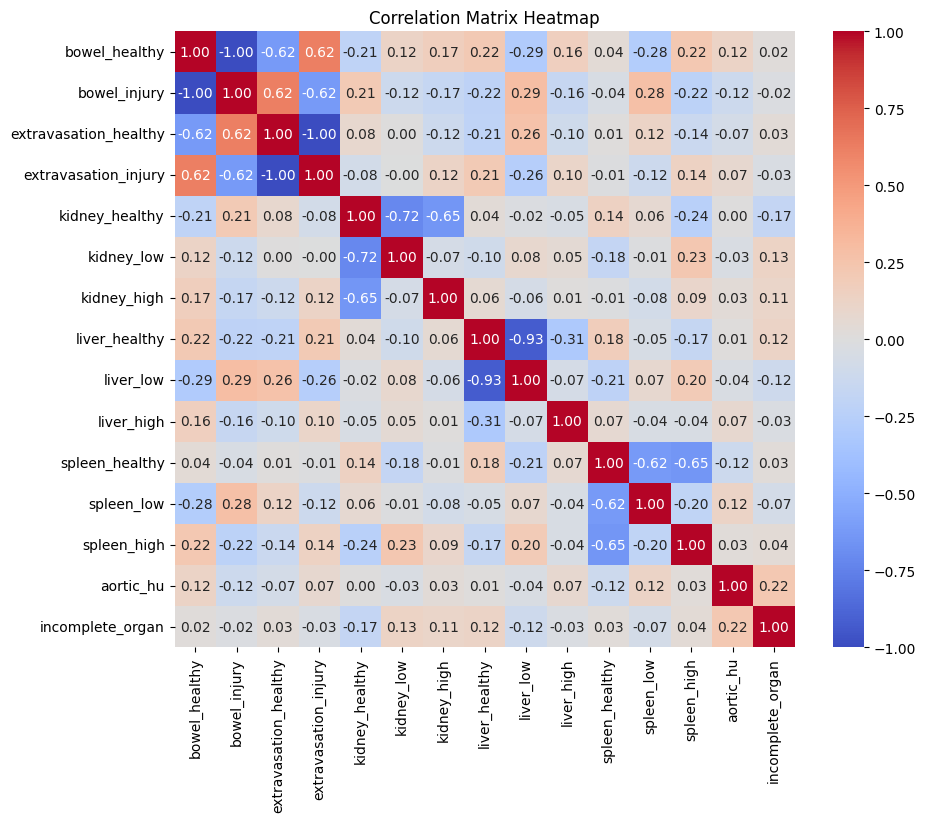

In [15]:
!pip install seaborn

import seaborn as sns
plt.figure(figsize=(10, 8))
# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add a title
plt.title('Correlation Matrix Heatmap')

# Show the plot
plt.show()

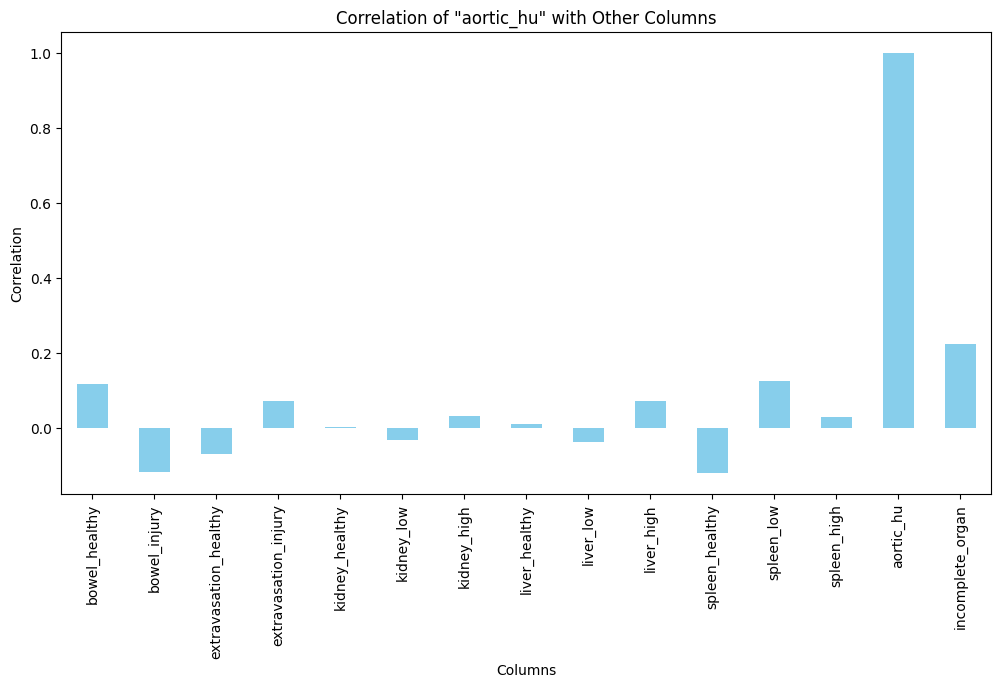

In [16]:
correlation_with_aortic_hu = corr_df.corr()['aortic_hu']
plt.figure(figsize=(12, 6))
corr_df.corr()['aortic_hu'].plot(kind='bar', color='skyblue')
plt.xlabel('Columns')
plt.ylabel('Correlation')
plt.title('Correlation of "aortic_hu" with Other Columns')
plt.xticks(rotation=90)
plt.show()

# **Data Understanding**

In [17]:
# Basic information for the 'train' dataset
train_info = {
    "Number of Rows": train.shape[0],
    "Number of Columns": train.shape[1],
    "Columns": train.columns.tolist(),
    "Data Types": train.dtypes.tolist(),
    "Unique Values per Column": train.nunique().tolist()
}

# Basic information for the 'labels' dataset
labels_info = {
    "Number of Rows": labels.shape[0],
    "Number of Columns": labels.shape[1],
    "Columns": labels.columns.tolist(),
    "Data Types": labels.dtypes.tolist(),
    "Unique Values per Column": labels.nunique().tolist()
}

# Basic information for the 'train_meta' dataset
train_meta_info = {
    "Number of Rows": train_meta.shape[0],
    "Number of Columns": train_meta.shape[1],
    "Columns": train_meta.columns.tolist(),
    "Data Types": train_meta.dtypes.tolist(),
    "Unique Values per Column": train_meta.nunique().tolist()
}

train_info, labels_info, train_meta_info

({'Number of Rows': 3147,
  'Number of Columns': 15,
  'Columns': ['patient_id',
   'bowel_healthy',
   'bowel_injury',
   'extravasation_healthy',
   'extravasation_injury',
   'kidney_healthy',
   'kidney_low',
   'kidney_high',
   'liver_healthy',
   'liver_low',
   'liver_high',
   'spleen_healthy',
   'spleen_low',
   'spleen_high',
   'any_injury'],
  'Data Types': [dtype('int64'),
   dtype('int64'),
   dtype('int64'),
   dtype('int64'),
   dtype('int64'),
   dtype('int64'),
   dtype('int64'),
   dtype('int64'),
   dtype('int64'),
   dtype('int64'),
   dtype('int64'),
   dtype('int64'),
   dtype('int64'),
   dtype('int64'),
   dtype('int64')],
  'Unique Values per Column': [3147,
   2,
   2,
   2,
   2,
   2,
   2,
   2,
   2,
   2,
   2,
   2,
   2,
   2,
   2]},
 {'Number of Rows': 12029,
  'Number of Columns': 4,
  'Columns': ['patient_id', 'series_id', 'instance_number', 'injury_name'],
  'Data Types': [dtype('int64'), dtype('int64'), dtype('int64'), dtype('O')],
  'Unique Va

**1. labels (image_level_labels.csv) Dataset:**

- Number of Rows: 12,029
- Number of Columns: 4
- Columns:
    - patient_id: Unique dentifier of the patient.
    - series_id: An identifier for the series of images associated with each patient..
    - instance_number: Specific image instance number within the series.
    - injury_name: Type of injury detected in the image.
- Data Types: The data types are appropriate with integer types for identifiers and object (string) type for the injury name.
- Unique Values: There are 246 unique patients, 330 unique series, and 925 unique instance numbers. The injury_name column has 2 unique values, indicating two types of injuries;  Active_Extravasation and bowel

**2. train(train.csv) Dataset:**

- Number of Rows: 3,147
- Number of Columns: 15
- Columns:
    - patient_id: Unique identifier of the patient.
    - The other 14 columns represent the health status and injury severity of various organs for each patient, recorded as binary variables where 0 indicates the absence of a condition, and 1 indicates the presence of a condition.
- Data Types: All columns are of integer type.
- Unique Values: There are 3,147 unique patients. The injury-related columns have binary values (0 or 1), indicating the absence or presence of a specific injury type.

**3. train_meta (train_series_meta.csv) Dataset:**

- Number of Rows: 4,711
- Number of Columns: 4
- Columns:
    - patient_id: Unique identifier of the patient.
    - series_id: An identifier for the series of images associated with each patient..
    - aortic_hu: A quantitative measure in HU related to the aorta.
    - incomplete_organ: A binary indicator where 0 signifies the absence of an incomplete organ, and 1 signifies the presence of an incomplete organ..
- Data Types: The data types are appropriate with integer and float types.
- Unique Values: There are 3,147 unique patients and 4,711 unique series. The incomplete_organ column has 2 unique values.

In [18]:
# Checking for missing values and duplicates
def check_missing_and_duplicates(datasets):
    # Initializing lists to store the results
    dataset_names = []
    missing_values_list = []
    duplicates_list = []
    
    for dataset_name, dataset in datasets.items():
        # Calculating missing values
        missing_values = dataset.isnull().sum().sum()
        
        # Checking for duplicates
        duplicates = dataset.duplicated().sum()
        
        # Appending 
        dataset_names.append(dataset_name)
        missing_values_list.append(missing_values)
        duplicates_list.append(duplicates)
    
    # Creating a summary DataFrame
    summary_df = pd.DataFrame({
        "Dataset": dataset_names,
        "Missing Values": missing_values_list,
        "Duplicates": duplicates_list
    })
    
    return summary_df

datasets = {
    "train": train,
    "labels": labels,
    "train_meta": train_meta
}

summary = check_missing_and_duplicates(datasets)

print(summary)

      Dataset  Missing Values  Duplicates
0       train               0           0
1      labels               0           0
2  train_meta               0           0


- There are no missing values in any of the datasets.
- There are no duplicated rows in any of the datasets.

In [19]:
print("Descriptive statistics for the train dataset:")
print(train.describe())

Descriptive statistics for the train dataset:
         patient_id  bowel_healthy  bowel_injury  extravasation_healthy  \
count   3147.000000    3147.000000   3147.000000            3147.000000   
mean   32664.239593       0.979663      0.020337               0.936447   
std    18792.043458       0.141172      0.141172               0.243993   
min       19.000000       0.000000      0.000000               0.000000   
25%    16355.500000       1.000000      0.000000               1.000000   
50%    32195.000000       1.000000      0.000000               1.000000   
75%    49302.500000       1.000000      0.000000               1.000000   
max    65508.000000       1.000000      1.000000               1.000000   

       extravasation_injury  kidney_healthy   kidney_low  kidney_high  \
count           3147.000000     3147.000000  3147.000000  3147.000000   
mean               0.063553        0.942167     0.036543     0.021290   
std                0.243993        0.233464     0.187666   

**Statistical Summary of the train dataset**

**1. Patient IDs Distribution:**

- Representing the unique patient identifier, the 'patient_id' column ranges from 19 to 65,508, suggesting a wide range of patients in the dataset.

**2. Organ Health Status:**

- Several columns (e.g., 'bowel_healthy', 'extravasation_healthy', 'kidney_healthy', 'liver_healthy', 'spleen_healthy') are binary indicators of organ health.
- On average, most patients have healthy organs, as indicated by values close to 1.
- The mean values of these columns are as per below:
    - The 'bowel_healthy' has an approximate mean of 0.98.
    - The 'extravasation_healthy' has a 0.94 mean.
    - The 'kidney_healthy' has 0.94 mean.
    - The 'liver_healthy'has a 0.90 mean.
    - The 'spleen_healthy' has a 0.89 mean.
- This suggests that these organ related injuries are relatively rare in the dataset.

**3. Organ Injury Severity:**

- Columns like 'bowel_injury', 'extravasation_injury', 'kidney_low', 'kidney_high', 'liver_low', 'liver_high', 'spleen_low', and 'spleen_high' represent binary indicators of injury severity for various organs.  The mean values of these columns are as per below:
    - The 'liver_high'has a mean of around 0.02 while 'liver_low' has a mean of 0.08. 
    - The 'spleen_high' is at 0.05 with 'spleen_low' at 0.06.
    - The 'kidney_high' is at 0.02 with 'kidney_low' at 0.04.
    - The 'bowel_injury' is at 0.02 with the 'extravasation_injury' at 0.06.
- These columns have low mean values, further confirming that severe injuries are relatively uncommon as compared to healthy organs.

**4. Overall Injury Presence:**

- The 'any_injury' column is a binary indicator of the presence of any injury in a patient.
- On average, approximately 27% of patients in the dataset have at least one injury (mean value of 0.27).

**Conclusions:**

- The dataset appears to be relatively imbalanced, with most patients having healthy organs and a minority experiencing injuries.

- Bowel injuries, extravasation injuries, kidney injuries, liver injuries, and spleen injuries are relatively rare, as indicated by low mean values for their respective columns.

- Most patients have healthy organs, suggesting that the dataset may contain a majority of cases without severe injuries.

**Approximately 27% of patients in the dataset have at least one injury, indicating that injuries, while less common, are still present in a significant portion of the population. This underscores the importance of conducting further EDA to gain deeper insights into the nature, patterns, and potential risk factors associated with these injuries. EDA will help us better understand the characteristics of injuries and their impact on patient outcomes, leading to more informed decision-making in the field of trauma care and intervention.**

## **Exploratory data Analysis**

### **Univariate Analysis**

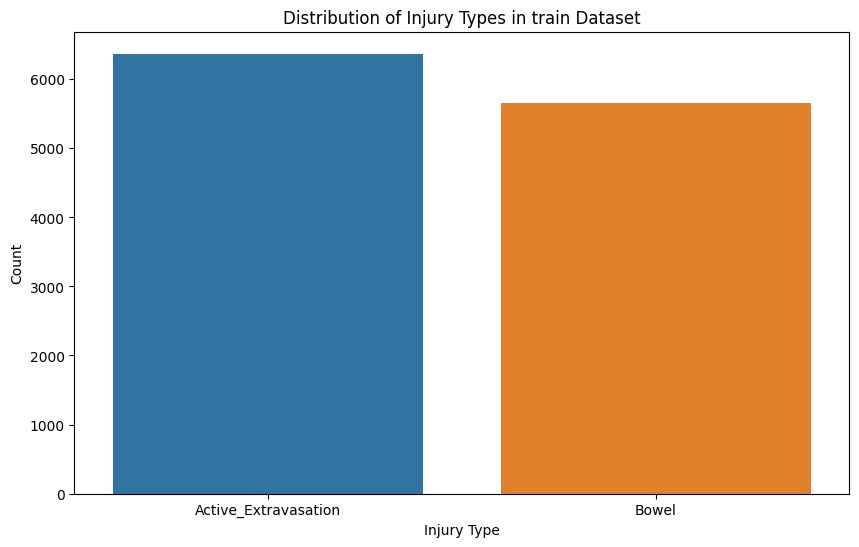

In [20]:
# Visualizing the distribution of injury types in the 'label' dataset
plt.figure(figsize=(10, 6))
sns.countplot(data=labels, x='injury_name')
plt.title('Distribution of Injury Types in train Dataset')
plt.ylabel('Count')
plt.xlabel('Injury Type')
plt.show()

The data suggests that extravasation (active bleeding) is more frequently identified in the provided images than bowel injuries.

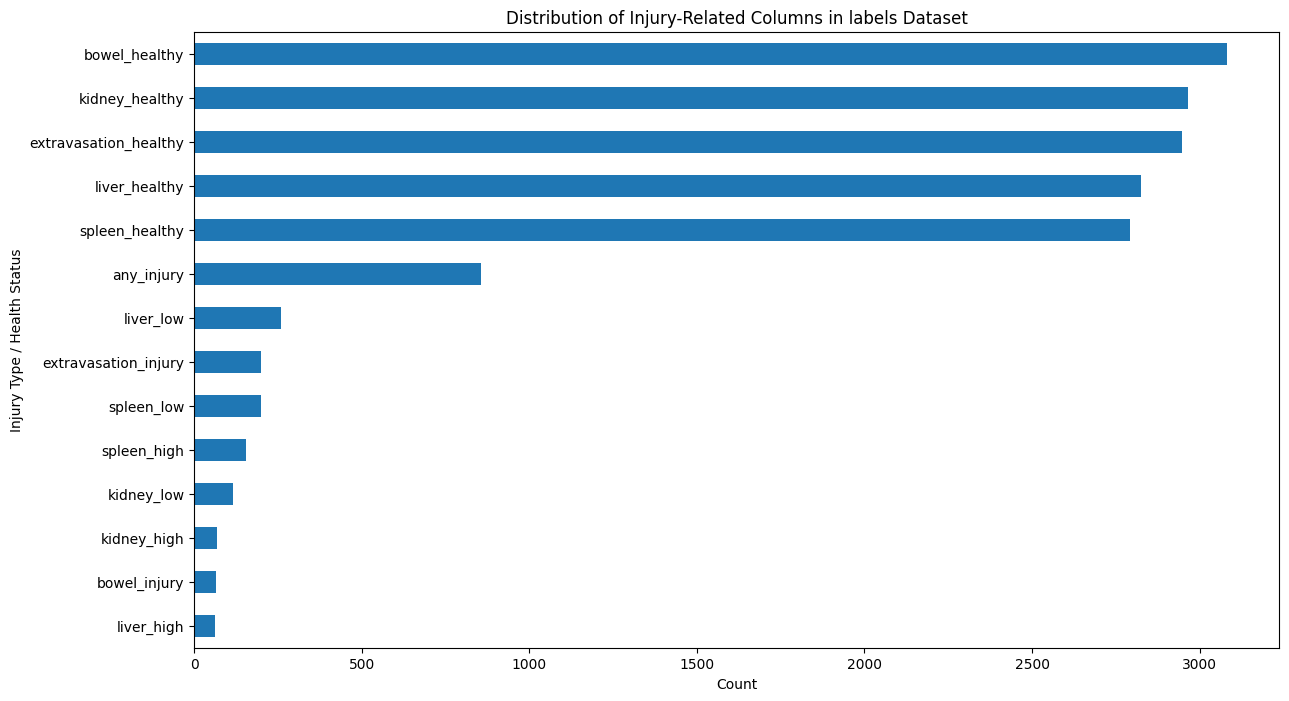

In [21]:
# Visualizing the distribution of injury-related columns in the 'train' dataset
injury_columns = [col for col in train.columns if col != "patient_id"]
injury_counts = train[injury_columns].sum()

plt.figure(figsize=(14, 8))
injury_counts.sort_values().plot(kind='barh')
plt.title('Distribution of Injury-Related Columns in labels Dataset')
plt.xlabel('Count')
plt.ylabel('Injury Type / Health Status')
plt.show()

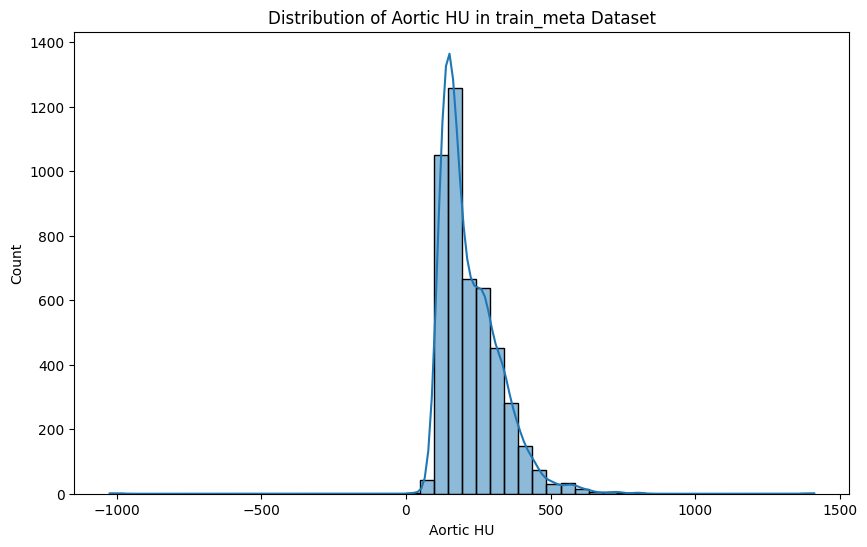

In [22]:
# Visualizing the distribution of the 'aortic_hu' column in the 'train_meta' dataset
plt.figure(figsize=(10, 6))
sns.histplot(train_meta['aortic_hu'], bins=50, kde=True)
plt.title('Distribution of Aortic HU in train_meta Dataset')
plt.xlabel('Aortic HU')
plt.ylabel('Count')
plt.show()

Hounsfield Units (HU) are a measure used in CT scans to describe radiodensity, and the distribution gives us an idea of the variation in these values across different images.

**Relationship Analysis:**

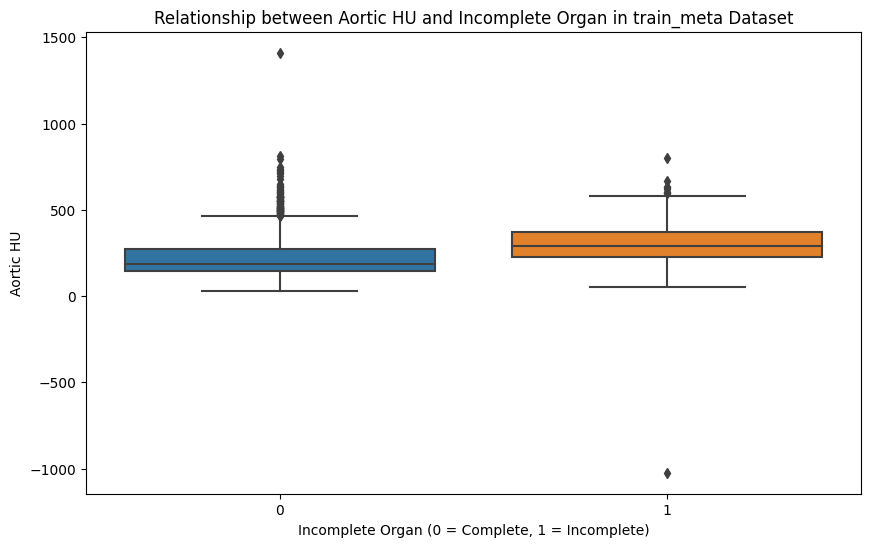

In [23]:
# Visualizing the relationship between 'aortic_hu' and 'incomplete_organ' in the 'train_meta' dataset
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_meta, x='incomplete_organ', y='aortic_hu')
plt.title('Relationship between Aortic HU and Incomplete Organ in train_meta Dataset')
plt.xlabel('Incomplete Organ (0 = Complete, 1 = Incomplete)')
plt.ylabel('Aortic HU')
plt.show()

This suggests that there might be some relationship between the completeness of the organ in the image and the aortic_hu values.

**Outliers Analysis:**

In [24]:
# Outlier analysis for the 'aortic_hu' column using the IQR method

# Calculate Q1, Q3, and IQR
Q1 = train_meta['aortic_hu'].quantile(0.25)
Q3 = train_meta['aortic_hu'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = train_meta[(train_meta['aortic_hu'] < lower_bound) | (train_meta['aortic_hu'] > upper_bound)]

# Percentage of data points that are outliers
outlier_percentage = (len(outliers) / len(train_meta)) * 100

outlier_summary = {
    "Lower Bound": lower_bound,
    "Upper Bound": upper_bound,
    "Number of Outliers": len(outliers),
    "Percentage of Outliers": outlier_percentage
}

outlier_summary

{'Lower Bound': -52.5,
 'Upper Bound': 479.5,
 'Number of Outliers': 103,
 'Percentage of Outliers': 2.186372320101889}

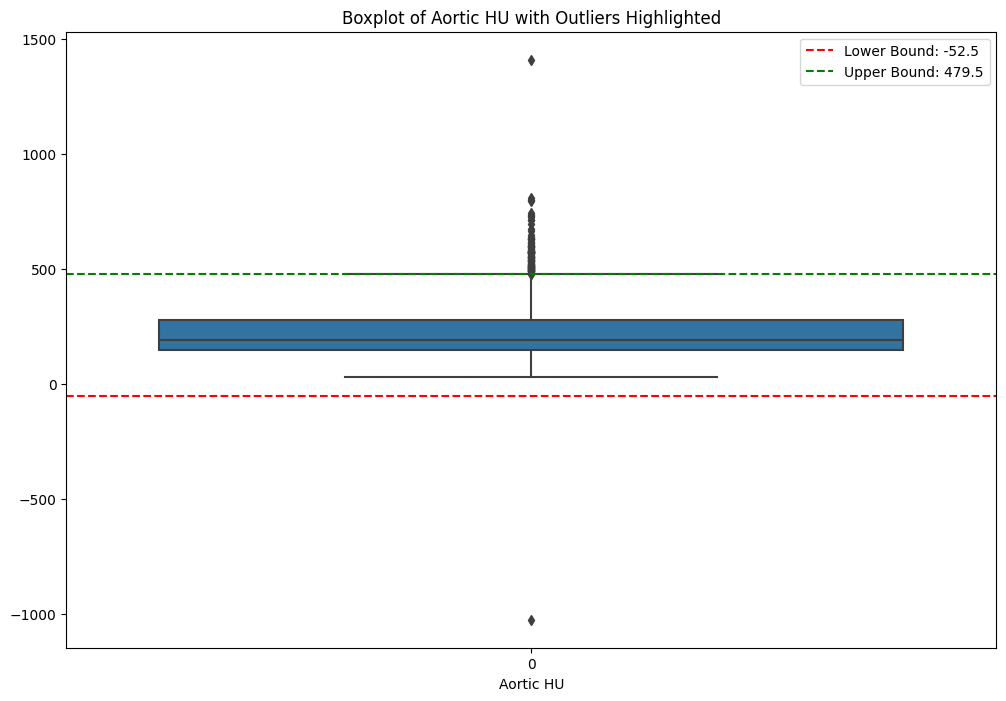

In [25]:
# Visualizing outliers for the 'aortic_hu' column
plt.figure(figsize=(12, 8))
sns.boxplot(train_meta['aortic_hu'])
plt.axhline(lower_bound, color='r', linestyle='--', label=f"Lower Bound: {lower_bound}")
plt.axhline(upper_bound, color='g', linestyle='--', label=f"Upper Bound: {upper_bound}")
plt.title('Boxplot of Aortic HU with Outliers Highlighted')
plt.xlabel('Aortic HU')
plt.legend()
plt.show()

From the plot, we can observe a cluster of data points above the upper bound, indicating potential outliers with higher aortic_hu values.

**Relationship Analysis:**

**1. Injury Type vs. Aortic HU:**

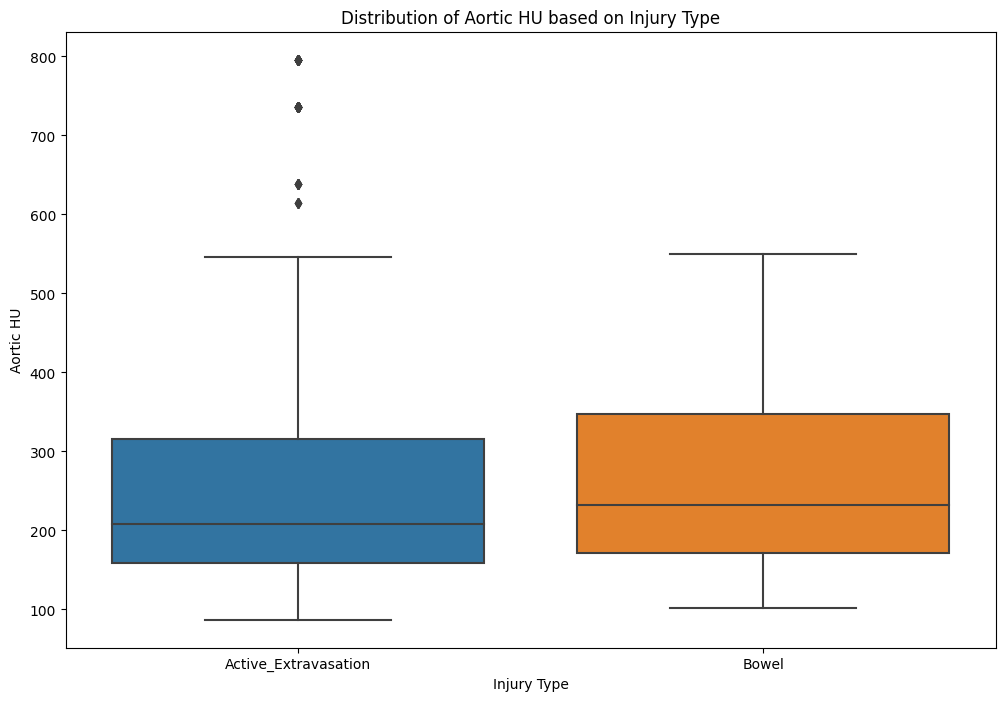

In [26]:
# Merging the 'label' and 'train_meta' datasets on 'patient_id' and 'series_id'
merged_data = pd.merge(labels, train_meta, on=['patient_id', 'series_id'])

# Visualizing the distribution of 'aortic_hu' based on 'injury_name'
plt.figure(figsize=(12, 8))
sns.boxplot(data=merged_data, x='injury_name', y='aortic_hu')
plt.title('Distribution of Aortic HU based on Injury Type')
plt.xlabel('Injury Type')
plt.ylabel('Aortic HU')
plt.show()

For bowel_injury, the distribution appears to have a slightly higher median and is more compact in terms of the interquartile range (IQR) compared to extravasation.
The extravasation injury (which represents active bleeding) has a broader IQR, indicating more variability in the aortic_hu values for this injury type. There are also a few potential outliers present for this injury type.

**2. Injury Type vs. Completeness of Organ:**

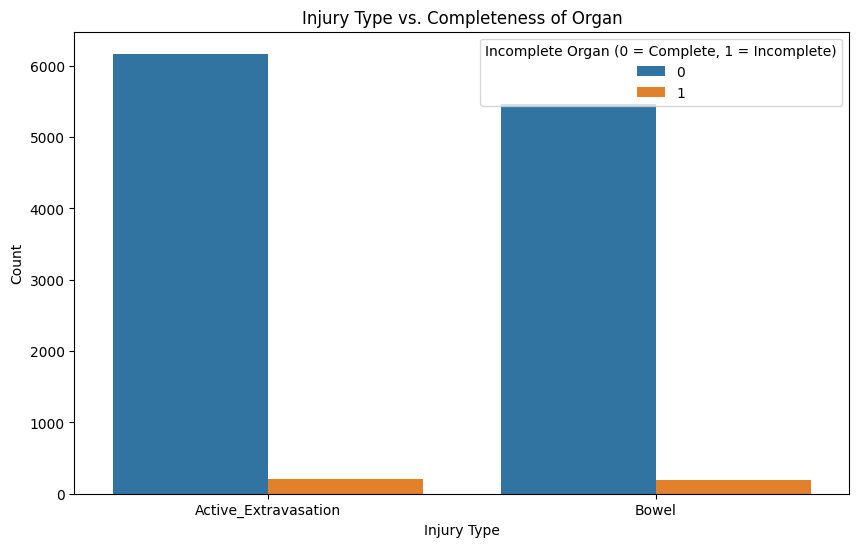

In [27]:
# Visualizing the relationship between 'injury_name' and 'incomplete_organ'
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_data, x='injury_name', hue='incomplete_organ')
plt.title('Injury Type vs. Completeness of Organ')
plt.xlabel('Injury Type')
plt.ylabel('Count')
plt.legend(title='Incomplete Organ (0 = Complete, 1 = Incomplete)')
plt.show()

For both bowel_injury and extravasation injury types, the majority of the organs in the images are complete (incomplete_organ = 0).
The number of images with incomplete organs (incomplete_organ = 1) is relatively lower for both injury types, with extravasation having a slightly higher count of incomplete organs compared to bowel_injury.

## Importing Images

Start by creating image paths for test dataset

In [28]:
# Adjusting the path generation function to exclude instance_number
def test_img_path(row):
    return f"/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images/{row['patient_id']}/{row['series_id']}/"

test_meta['test_img_path'] = test_meta.apply(test_img_path, axis=1)

# Display the first few rows of the test_meta dataframe with the new 'adjusted_img_path' column
test_meta.head()

patient_id  series_id  aortic_hu  \
0       48843        295     401.25   
1       48843      62825     238.00   
2       50046      24574     149.00   
3       50046      60658     352.00   
4       63706      39279     219.00   

                                       test_img_path  
0  /kaggle/input/rsna-2023-abdominal-trauma-detec...  
1  /kaggle/input/rsna-2023-abdominal-trauma-detec...  
2  /kaggle/input/rsna-2023-abdominal-trauma-detec...  
3  /kaggle/input/rsna-2023-abdominal-trauma-detec...  
4  /kaggle/input/rsna-2023-abdominal-trauma-detec...

Craeting image path for train dataset

In [29]:
def img_path(row):
    return f"/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/{row['patient_id']}/{row['series_id']}/{row['instance_number']}.dcm"

labels['img_path'] = labels.apply(img_path, axis=1)

**DICOM Image Visualization:**

In [30]:
# Generating Kaggle reference paths for the 'train' dataset again
labels['img_path'] = labels.apply(img_path, axis=1)

# Displaying the first few rows of the 'train' dataset with the updated 'img_path' column
labels.head()

patient_id  series_id  instance_number           injury_name  \
0       10004      21057              362  Active_Extravasation   
1       10004      21057              363  Active_Extravasation   
2       10004      21057              364  Active_Extravasation   
3       10004      21057              365  Active_Extravasation   
4       10004      21057              366  Active_Extravasation   

                                            img_path  
0  /kaggle/input/rsna-2023-abdominal-trauma-detec...  
1  /kaggle/input/rsna-2023-abdominal-trauma-detec...  
2  /kaggle/input/rsna-2023-abdominal-trauma-detec...  
3  /kaggle/input/rsna-2023-abdominal-trauma-detec...  
4  /kaggle/input/rsna-2023-abdominal-trauma-detec...

In [31]:
labels.shape

(12029, 5)

In [32]:
def is_valid_image(img_path):
    return os.path.exists(img_path)
# Assuming your DataFrame is named 'labels'
labels = labels[labels['img_path'].apply(is_valid_image)]
labels.shape

(12029, 5)

Ramdomly display injury type and image

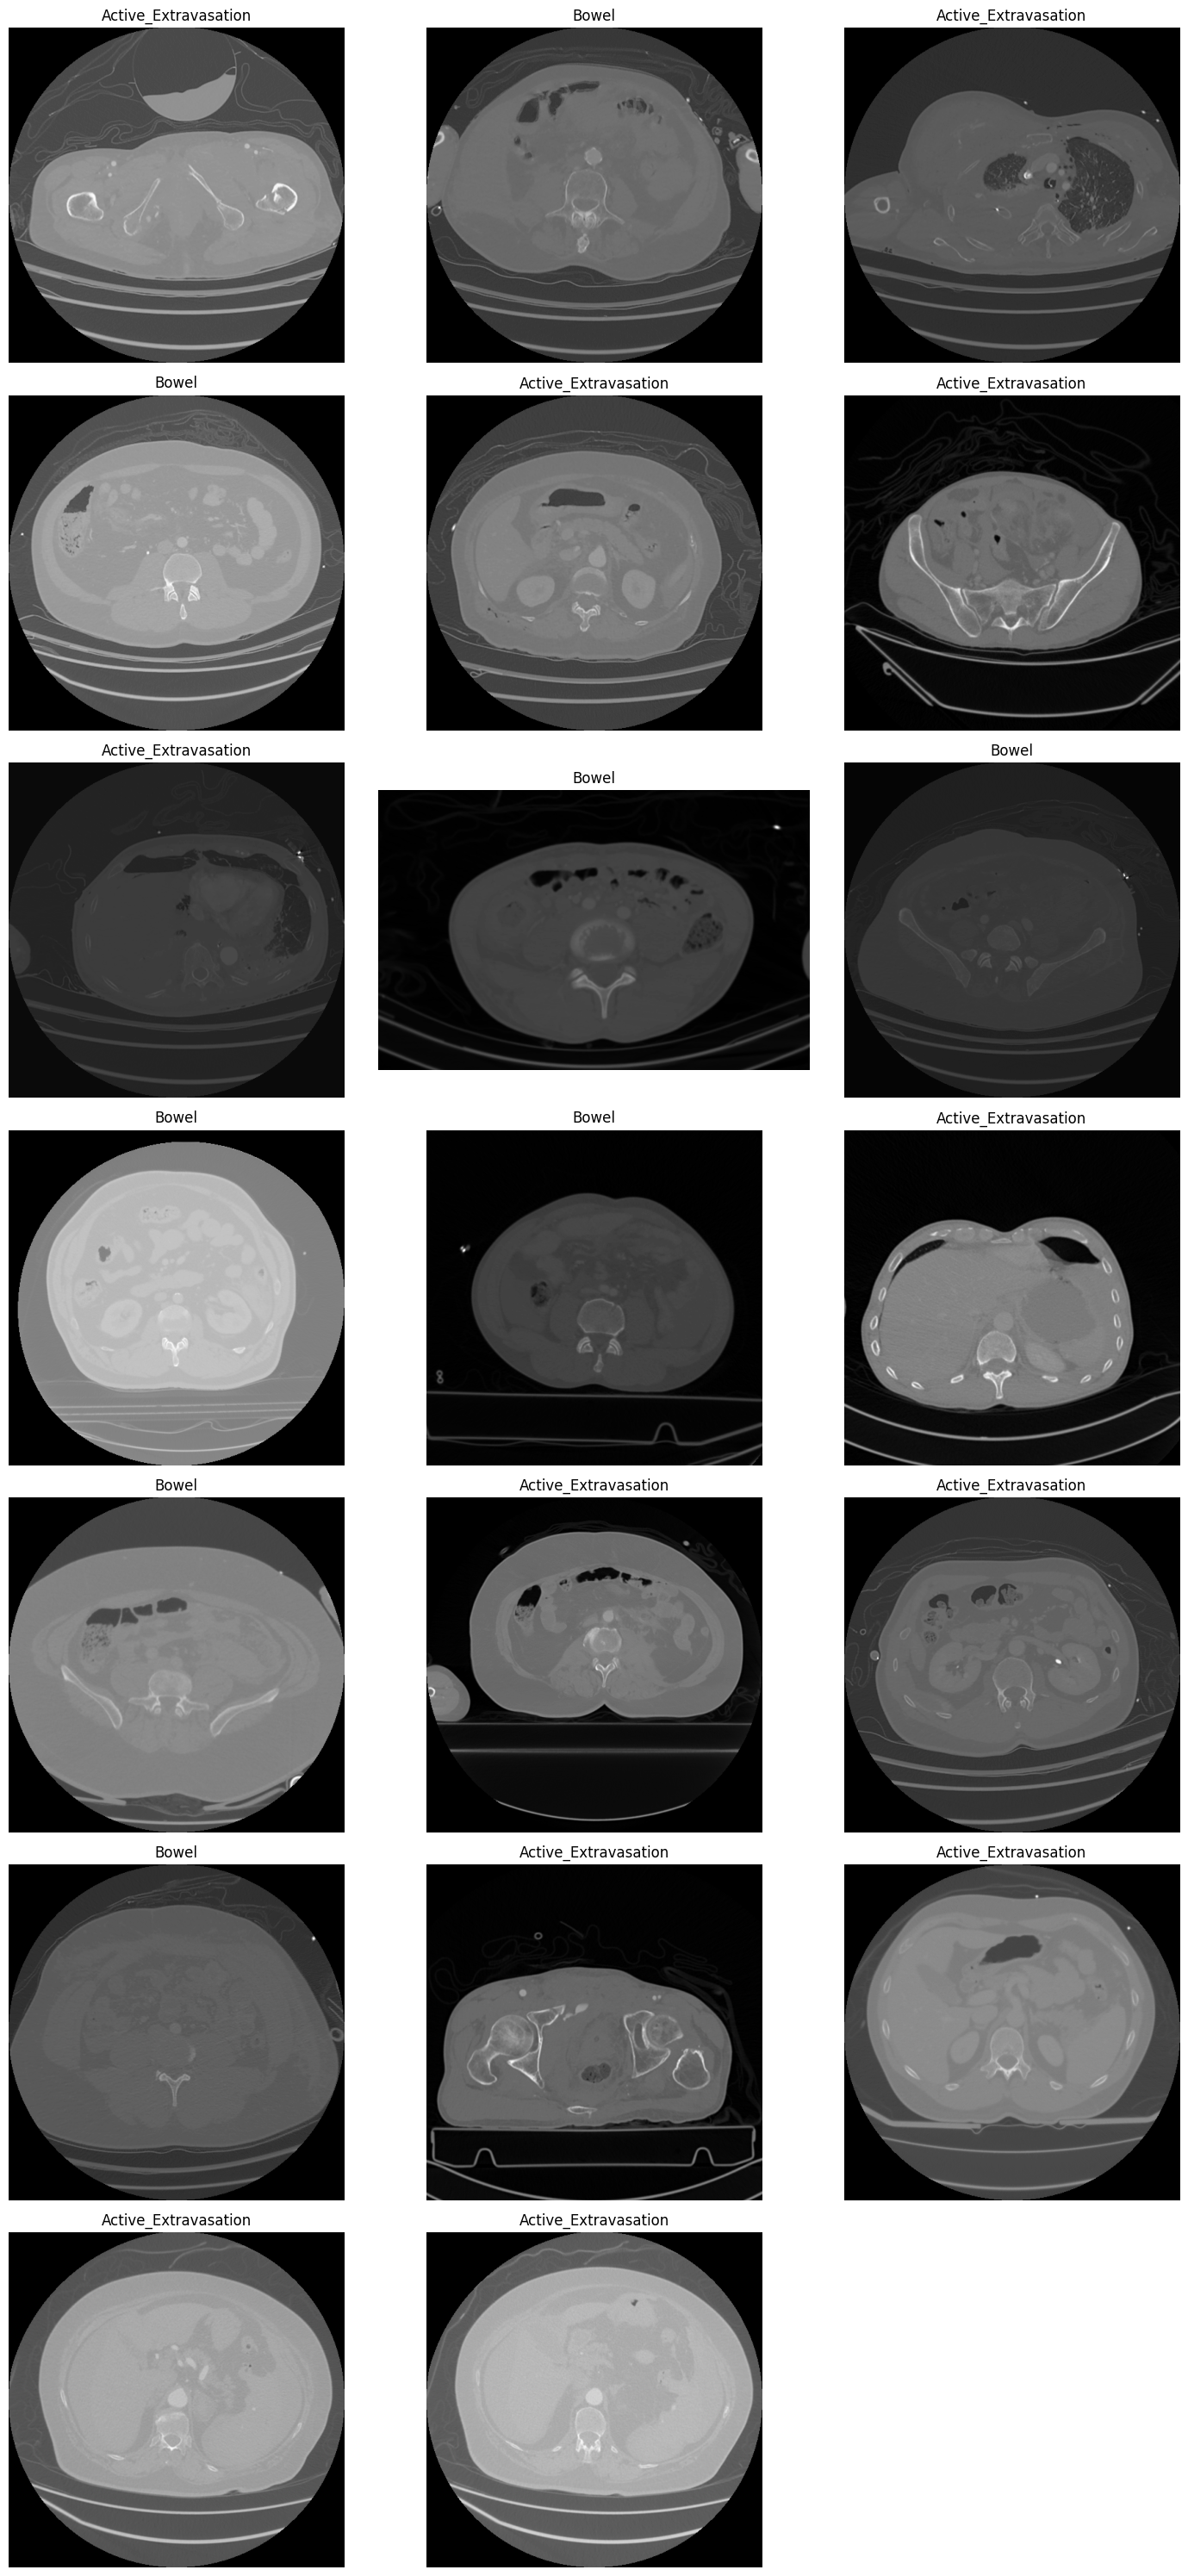

In [33]:
!pip install pydicom

import pydicom
import matplotlib.pyplot as plt

def read_dicom_image(path):
    """
    Reads a DICOM image and returns its pixel array.
    """
    dicom_img = pydicom.dcmread(path)
    return dicom_img.pixel_array

# Sample 20 rows from the train dataset
sample_data = labels.sample(20)

# Extract the img_paths and corresponding injury names for labeling
sample_img_paths = sample_data['img_path'].tolist()
sample_labels = sample_data['injury_name'].tolist()

# Set up the figure for visualization
plt.figure(figsize=(15, 30))

# Loop through the sampled image paths and display them in rows of 3 with labels
for idx, (img_path, label) in enumerate(zip(sample_img_paths, sample_labels), start=1):
    plt.subplot(7, 3, idx)  # 7 rows, 3 columns
    plt.imshow(read_dicom_image(img_path), cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

**comparison of images for each injury type**

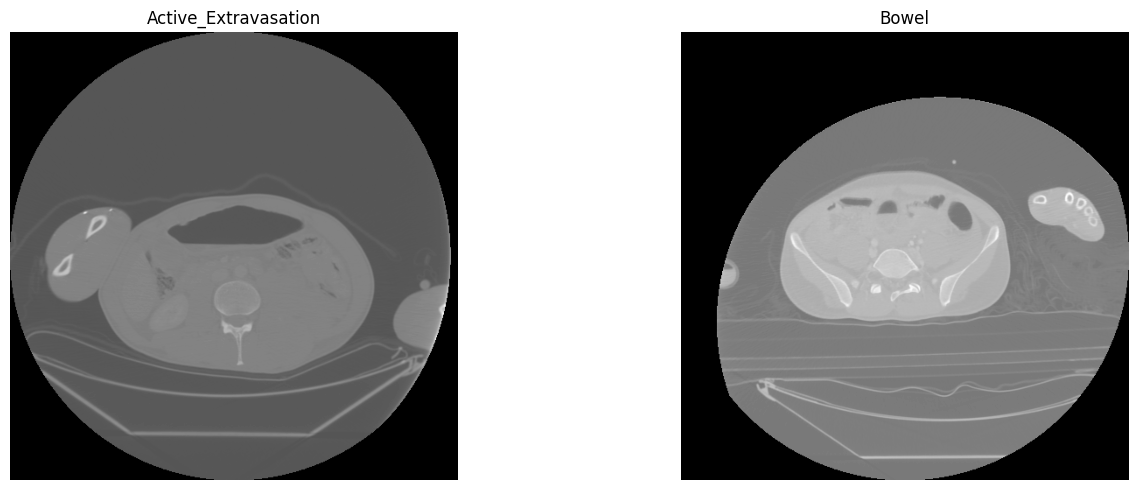

In [34]:
import pydicom
import matplotlib.pyplot as plt

def read_dicom_image(path):
    """
    Reads a DICOM image and returns its pixel array.
    """
    dicom_img = pydicom.dcmread(path)
    return dicom_img.pixel_array

# Sample one image path for each injury type
sample_img_paths = labels.groupby('injury_name').apply(lambda x: x.sample(1)['img_path'].values[0])
sample_labels = sample_img_paths.index.tolist()

# Set up the figure for visualization
plt.figure(figsize=(15, 5))

# Loop through the sampled image paths and display them side by side with labels
for idx, (img_path, label) in enumerate(zip(sample_img_paths, sample_labels), start=1):
    plt.subplot(1, len(sample_img_paths), idx)
    plt.imshow(read_dicom_image(img_path), cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

Randomly Display Images by Patient ID

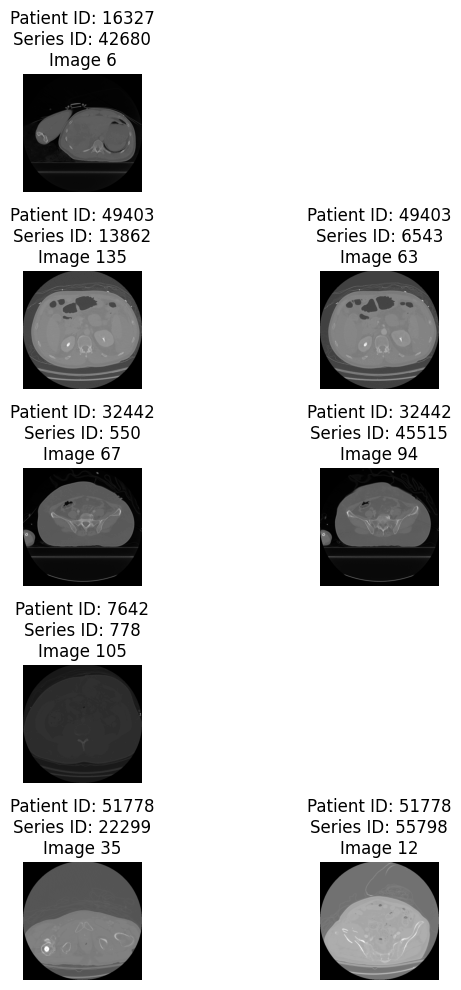

In [35]:
import pydicom
import matplotlib.pyplot as plt
import random

def read_dicom_image(path):
    """
    Reads a DICOM image and returns its pixel array.
    """
    dicom_img = pydicom.dcmread(path)
    return dicom_img.pixel_array

# Get unique patient IDs from your DataFrame
unique_patient_ids = labels['patient_id'].unique()

# Randomly select 5 patient IDs (or you can select a fixed set)
random_patient_ids = random.sample(list(unique_patient_ids), 5)

# Set up a grid for displaying images
num_rows = 5  # Number of rows in the grid (one row per patient)
num_cols = 5  # Number of columns in the grid (up to 5 images per patient)
plt.figure(figsize=(15, 10))

# Iterate through randomly selected patient IDs
for row, random_patient_id in enumerate(random_patient_ids, start=1):
    # Filter the DataFrame to get all images for the randomly selected patient
    patient_images = labels[labels['patient_id'] == random_patient_id]
    
    # Get unique series IDs for the patient
    unique_series_ids = patient_images['series_id'].unique()
    
    # Randomly select up to 5 unique series IDs (you can adjust the number)
    random_series_ids = random.sample(list(unique_series_ids), min(5, len(unique_series_ids)))
    
    # Iterate through randomly selected series IDs for the patient
    for col, random_series_id in enumerate(random_series_ids, start=1):
        # Filter the DataFrame to get all images for the selected series
        series_images = patient_images[patient_images['series_id'] == random_series_id]
        
        # Display each image in the series
        for i, (_, image_row) in enumerate(series_images.iterrows(), start=1):
            image_path = image_row['img_path']
            plt.subplot(num_rows, num_cols, (row - 1) * num_cols + col)
            plt.imshow(read_dicom_image(image_path), cmap='gray')
            plt.title(f'Patient ID: {random_patient_id}\nSeries ID: {random_series_id}\nImage {i}')
            plt.axis('off')

plt.tight_layout()
plt.show()

**preprocessing :**


* Rescaling: Adjusting the intensity values to a standard scale, e.g., between 0 and 1.
* Resizing: Making sure all images have the same size, especially if they are being fed into a neural network.
* Histogram Equalization: Enhancing the contrast of images.
* Normalization: Removing the mean and scaling to unit variance.
* Data Augmentation: Techniques such as rotation, zooming, and flipping to artificially increase the size of the dataset (useful for training deep learning models).
* Smoothing
*Padding

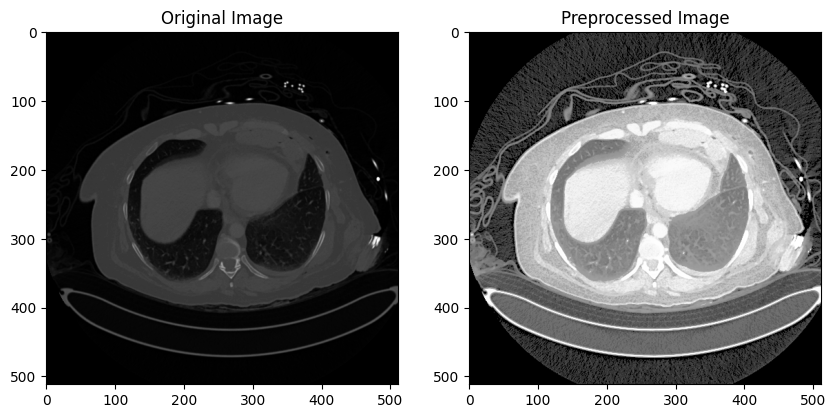

In [36]:
import pydicom
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load a sample DICOM image
sample_path = labels['img_path'].iloc[0]
dicom_img = pydicom.dcmread(sample_path).pixel_array

# Rescale the image to the range [0, 1]
rescaled_img = cv2.normalize(dicom_img, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Apply histogram equalization
equalized_img = cv2.equalizeHist((rescaled_img * 255).astype(np.uint8))

# Plot original and preprocessed images side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(dicom_img, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(equalized_img, cmap='gray')
plt.title('Preprocessed Image')
plt.show()

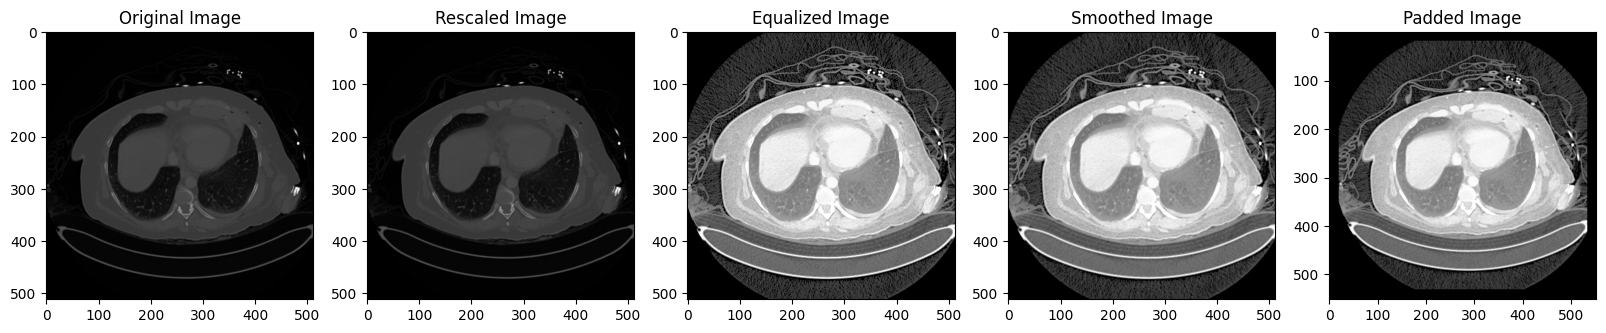

In [37]:
import pydicom
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to read a DICOM image and return its pixel array
def read_dicom_image(path):
    dicom_img = pydicom.dcmread(path)
    return dicom_img.pixel_array

# Load a sample DICOM image
sample_path = labels['img_path'].iloc[0]
dicom_img = read_dicom_image(sample_path)

# Rescale the image to the range [0, 1]
rescaled_img = cv2.normalize(dicom_img, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Apply histogram equalization
equalized_img = cv2.equalizeHist((rescaled_img * 255).astype(np.uint8))

# Apply Gaussian smoothing
k_size = (5, 5)  # Kernel size for Gaussian filter
sigma = 0.5      # Standard deviation for Gaussian filter
smoothed_img = cv2.GaussianBlur(equalized_img, k_size, sigma)

# Define padding size (top, bottom, left, right)
padding_size = (20, 20, 20, 20)

# Apply zero-padding
padded_img = np.pad(smoothed_img, ((padding_size[0], padding_size[1]), (padding_size[2], padding_size[3])), mode='constant', constant_values=0)

# Plot original, rescaled, equalized, smoothed, and padded images
plt.figure(figsize=(20, 8))
plt.subplot(1, 5, 1)
plt.imshow(dicom_img, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 5, 2)
plt.imshow(rescaled_img, cmap='gray')
plt.title('Rescaled Image')

plt.subplot(1, 5, 3)
plt.imshow(equalized_img, cmap='gray')
plt.title('Equalized Image')

plt.subplot(1, 5, 4)
plt.imshow(smoothed_img, cmap='gray')
plt.title('Smoothed Image')

plt.subplot(1, 5, 5)
plt.imshow(padded_img, cmap='gray')
plt.title('Padded Image')

plt.show()

In [38]:
import pydicom
import cv2
import numpy as np
import pandas as pd
import gc

def read_dicom_image(path):
    dicom_img = pydicom.dcmread(path)
    return dicom_img.pixel_array

def process_image(img):
    rescaled_img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    equalized_img = cv2.equalizeHist((rescaled_img * 255).astype(np.uint8))
    k_size = (5, 5)
    sigma = 0.5
    smoothed_img = cv2.GaussianBlur(equalized_img, k_size, sigma)
    padding_size = (20, 20, 20, 20)
    padded_img = np.pad(smoothed_img, ((padding_size[0], padding_size[1]), (padding_size[2], padding_size[3])), mode='constant', constant_values=0)
    
    # Resize to a fixed size
    resized_img = cv2.resize(padded_img, (256, 256))
    
    return resized_img / 255.0  # normalize to [0,1]

def process_batch(batch):
    batch_images = []
    for index, row in batch.iterrows():
        img = read_dicom_image(row['img_path'])
        processed_img = process_image(img)
        batch_images.append(processed_img)
    return np.stack(batch_images)

def image_generator(labels_df, batch_size):
    num_samples = len(labels_df)
    
    while True:
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch = labels_df.iloc[start:end]
            batch_images = process_batch(batch)
            
            yield batch_images
            
            # Free up memory
            del batch_images
            gc.collect()

# Sample usage
batch_size = 100
data_gen = image_generator(labels, batch_size=batch_size)

# To get the next batch of images:
# next_batch = next(data_gen)


In [39]:
labels.head()

patient_id  series_id  instance_number           injury_name  \
0       10004      21057              362  Active_Extravasation   
1       10004      21057              363  Active_Extravasation   
2       10004      21057              364  Active_Extravasation   
3       10004      21057              365  Active_Extravasation   
4       10004      21057              366  Active_Extravasation   

                                            img_path  
0  /kaggle/input/rsna-2023-abdominal-trauma-detec...  
1  /kaggle/input/rsna-2023-abdominal-trauma-detec...  
2  /kaggle/input/rsna-2023-abdominal-trauma-detec...  
3  /kaggle/input/rsna-2023-abdominal-trauma-detec...  
4  /kaggle/input/rsna-2023-abdominal-trauma-detec...

In [40]:
labels.shape

(12029, 5)

**Modelling**

**Steps for Model Building:**
* Data Preparation: Split the data into training and validation sets.
* Data Augmentation: Use data augmentation techniques to artificially increase the size of the training dataset.
* Model Architecture: Define the CNN architecture.
* Model Compilation: Specify the loss function, optimizer, and metrics.
* Model Training: Train the model using the training data.
* Model Evaluation: Evaluate the model's performance on the validation data.

**Model 2
Data Augmentataion**

In [41]:

model2_df = pd.merge(labels,train, on='patient_id', how='inner')

**Model spliting**

In [42]:
from sklearn.model_selection import train_test_split

# Define column names for labels
y_train_columns = ["bowel_injury", "extravasation_injury",
                   "kidney_healthy", "kidney_low", "kidney_high",
                   "liver_healthy", "liver_low", "liver_high",
                   "spleen_healthy", "spleen_low", "spleen_high"]

def batch_generator(data_df, batch_size):
    while True:
        for start in range(0, len(data_df), batch_size):
            end = min(start + batch_size, len(data_df))
            batch_df = data_df.iloc[start:end]
            batch_images = process_batch(batch_df)
            batch_labels = batch_df[y_train_columns].values
            yield batch_images, batch_labels

# Splitting the data into training (80%) and validation (20%) sets by patient IDs
train_patient_ids, val_patient_ids = train_test_split(model2_df['patient_id'].unique(), 
                                                      test_size=0.2, 
                                                      random_state=42)

# Use boolean indexing to filter rows in model_df based on patient IDs
train_df = model2_df[model2_df['patient_id'].isin(train_patient_ids)]
val_df = model2_df[model2_df['patient_id'].isin(val_patient_ids)]

# Create generators for training and validation
#batch_size = 32
#train_gen = batch_generator(train_df, batch_size=batch_size)
#val_gen = batch_generator(val_df, batch_size=batch_size)

# Number of steps per epoch
#train_steps_per_epoch = len(train_df) // batch_size
#val_steps_per_epoch = len(val_df) // batch_size


**Checking for class balance**

# Checking class balance for each individual label in the training set
train_class_balance_readable = {}

for column in y_train_columns:
    train_class_balance_readable[column] = train_df[column].value_counts().to_dict()

print("Class balance in training set:")
print(train_class_balance_readable)

# Checking class balance for each individual label in the validation set
val_class_balance_readable = {}

for column in y_train_columns:
    val_class_balance_readable[column] = val_df[column].value_counts().to_dict()

print("\nClass balance in validation set:")
print(val_class_balance_readable)



**Upsampling minority class**

In [43]:
from sklearn.utils import resample

# Identify majority and minority class combinations
class_combinations_counts = train_df[y_train_columns].value_counts()
majority_class_combination = class_combinations_counts.idxmax()
minority_class_combinations = class_combinations_counts.index[class_combinations_counts != class_combinations_counts.max()].tolist()

df_majority = train_df[train_df[y_train_columns].apply(tuple, axis=1) == majority_class_combination]
dfs_upsampled = [df_majority]

# Upsample each minority class combination
for minority_class_combination in minority_class_combinations:
    condition = (train_df[y_train_columns].apply(tuple, axis=1) == minority_class_combination)
    df_minority = train_df[condition]
    
    df_minority_upsampled = resample(df_minority, 
                                     replace=True, 
                                     n_samples=len(df_majority), 
                                     random_state=42)
    
    dfs_upsampled.append(df_minority_upsampled)

# Combine the majority class with the upsampled minority classes
df_upsampled = pd.concat(dfs_upsampled)

# Shuffle the dataframe to mix the data
train_df = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)


**confirming class balance**

In [44]:
# Checking class balance for each individual label in the upsampled training set
class_balance_readable = {}

for column in y_train_columns:
    class_balance_readable[column] = train_df[column].value_counts().to_dict()

class_balance_readable


{'bowel_injury': {0: 46854, 1: 36442},
 'extravasation_injury': {1: 59869, 0: 23427},
 'kidney_healthy': {1: 41648, 0: 41648},
 'kidney_low': {0: 62472, 1: 20824},
 'kidney_high': {0: 62472, 1: 20824},
 'liver_healthy': {0: 41648, 1: 41648},
 'liver_low': {0: 52060, 1: 31236},
 'liver_high': {0: 72884, 1: 10412},
 'spleen_healthy': {0: 46854, 1: 36442},
 'spleen_low': {0: 59869, 1: 23427},
 'spleen_high': {0: 59869, 1: 23427}}

# Check class balance in the validation set
class_balance_val = val_df[y_train_columns].sum().to_dict()
class_balance_val


**IMage augmentation and preprosssing**

In [45]:
import pydicom
import cv2
import numpy as np
import pandas as pd
import gc

# Read DICOM image from a file path
def read_dicom_image(path):
    dicom_img = pydicom.dcmread(path)
    return dicom_img.pixel_array

# Augmentation
def augment_image(img):
    # Random rotation
    angle = np.random.randint(-15, 15)
    M = cv2.getRotationMatrix2D((img.shape[1] // 2, img.shape[0] // 2), angle, 1)
    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

    # Random flip
    if np.random.rand() > 0.5:
        img = cv2.flip(img, 1)  # horizontal flip

    return img

# Process the image
def process_image(img):
    rescaled_img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    equalized_img = cv2.equalizeHist((rescaled_img * 255).astype(np.uint8))
    k_size = (5, 5)
    sigma = 0.5
    smoothed_img = cv2.GaussianBlur(equalized_img, k_size, sigma)
    padding_size = (20, 20, 20, 20)
    padded_img = np.pad(smoothed_img, ((padding_size[0], padding_size[1]), (padding_size[2], padding_size[3])), mode='constant', constant_values=0)
    
    # Resize to a fixed size
    resized_img = cv2.resize(padded_img, (256, 256))
    
    return resized_img / 255.0  # normalize to [0,1]

# Process a batch of images
def process_batch(batch):
    batch_images = []
    for index, row in batch.iterrows():
        img = read_dicom_image(row['img_path'])
        processed_img = process_image(img)
        batch_images.append(processed_img)
    return np.stack(batch_images)

def image_generator(labels_df, batch_size):
    num_samples = len(labels_df)
    
    while True:
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch = labels_df.iloc[start:end]
            batch_images = process_batch(batch)
            
            # Define labels for each task
            labels_bowel = batch['bowel_injury'].values  # Binary classification
            labels_extravasation = batch['extravasation_injury'].values  # Binary classification
            
            labels_kidney = batch[['kidney_healthy', 'kidney_low', 'kidney_high']].values  # Multi-class (3 classes)
            labels_liver = batch[['liver_healthy', 'liver_low', 'liver_high']].values  # Multi-class (3 classes)
            labels_spleen = batch[['spleen_healthy', 'spleen_low', 'spleen_high']].values  # Multi-class (3 classes)
            
            # Yield the batch of images and labels
            yield batch_images, [labels_bowel, labels_extravasation, labels_kidney, labels_liver, labels_spleen]
            
            # Free up memory
            del batch_images
            gc.collect()

# Sample usage
batch_size = 100
train_gen = image_generator(train_df, batch_size=batch_size)
val_gen = image_generator(val_df, batch_size=batch_size)

# To get the next batch of images and labels for training:
X_train_batch, y_train_batch = next(train_gen)

# And for validation:
X_val_batch, y_val_batch = next(val_gen)

In [46]:
import tensorflow as tf
from tensorflow import keras

# Mocking some values for config
class Config:
    IMAGE_SIZE = (256, 256)
    BATCH_SIZE = 200

config = Config()


Marking Down Model 1

import tensorflow as tf
from tensorflow import keras

# Mocking some values for config
class Config:
    IMAGE_SIZE = (256, 256)
    BATCH_SIZE = 200

config = Config()

# 1. Detect and initialize the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# 2. Instantiate a distribution strategy
#tpu_strategy = tf.distribute.TPUStrategy(tpu)

# 3. Define a function to create the model within the strategy scope
def create_model():
    # Define Input
    inputs = keras.Input(shape=config.IMAGE_SIZE + (1,), batch_size=config.BATCH_SIZE)  # Use a tuple instead of a list

    # Define Backbone
    # Using standard ResNet50 from keras
    backbone = keras.applications.ResNet50(include_top=False, weights=None, input_tensor=inputs)
    x = backbone.output

    # GAP to get the activation maps
    gap = keras.layers.GlobalAveragePooling2D()
    x = gap(x)

    # Adding dropout for regularization
    x = keras.layers.Dropout(0.5)(x)

    # Define 'necks' for each head
    x_bowel = keras.layers.Dense(32, activation='relu')(x)
    x_extra = keras.layers.Dense(32, activation='relu')(x)
    x_liver = keras.layers.Dense(32, activation='relu')(x)
    x_kidney = keras.layers.Dense(32, activation='relu')(x)
    x_spleen = keras.layers.Dense(32, activation='relu')(x)

    # Define heads
    out_bowel = keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel)
    out_extra = keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra)
    out_liver = keras.layers.Dense(3, name='liver', activation='softmax')(x_liver)
    out_kidney = keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney)
    out_spleen = keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen)

    # Concatenate the outputs
    outputs = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    return keras.Model(inputs=inputs, outputs=outputs)

# 4. Create the model within the strategy scope
#with tpu_strategy.scope():
    #model = create_model()

    # Cosine Decay
    cosine_decay = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=0.0
    )

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=cosine_decay)
    loss = {
        "bowel": keras.losses.BinaryCrossentropy(),
        "extra": keras.losses.BinaryCrossentropy(),
        "liver": keras.losses.CategoricalCrossentropy(),
        "kidney": keras.losses.CategoricalCrossentropy(),
        "spleen": keras.losses.CategoricalCrossentropy(),
    }
    metrics = {
        "bowel": ["accuracy"],
        "extra": ["accuracy"],
        "liver": ["accuracy"],
        "kidney": ["accuracy"],
        "spleen": ["accuracy"],
    }

    # Compile the model within the strategy scope
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# 5. Print the model summary
model.summary()


# Modified model-building code
# Mocking some values needed for training
# These are just placeholders since we don't have the actual values in this environment.
warmup_steps = 10
decay_steps = 100
# Define Input
# Define Input
inputs = keras.Input(shape=config.IMAGE_SIZE + (1,), batch_size=config.BATCH_SIZE)  # Use a tuple instead of a list

# Define Backbone
# Using standard ResNet50 from keras
backbone = keras.applications.ResNet50(include_top=False, weights=None, input_tensor=inputs)
x = backbone.output

# GAP to get the activation maps
gap = keras.layers.GlobalAveragePooling2D()
x = gap(x)

# Adding dropout for regularization
x = keras.layers.Dropout(0.5)(x)

# Define 'necks' for each head
x_bowel = keras.layers.Dense(32, activation='relu')(x)
x_extra = keras.layers.Dense(32, activation='relu')(x)
x_liver = keras.layers.Dense(32, activation='relu')(x)
x_kidney = keras.layers.Dense(32, activation='relu')(x)
x_spleen = keras.layers.Dense(32, activation='relu')(x)

# Define heads
out_bowel = keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel)
out_extra = keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra)
out_liver = keras.layers.Dense(3, name='liver', activation='softmax')(x_liver)
out_kidney = keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney)
out_spleen = keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen)

# Concatenate the outputs
outputs = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

# Create model
print("[INFO] Building the model...")
model = keras.Model(inputs=inputs, outputs=outputs)

# Cosine Decay
cosine_decay = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=decay_steps,
    alpha=0.0
)

 # Compile the model
optimizer = keras.optimizers.Adam(learning_rate=cosine_decay)
loss = {
        "bowel":keras.losses.BinaryCrossentropy(),
        "extra":keras.losses.BinaryCrossentropy(),
        "liver":keras.losses.CategoricalCrossentropy(),
        "kidney":keras.losses.CategoricalCrossentropy(),
        "spleen":keras.losses.CategoricalCrossentropy(),
    }
metrics = {
        "bowel":["accuracy"],
        "extra":["accuracy"],
        "liver":["accuracy"],
        "kidney":["accuracy"],
        "spleen":["accuracy"],
    }
print("[INFO] Compiling the model...")
# Consider adding 'loss_weights' if needed
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()


# Mocking some values needed for training
# These are just placeholders since we don't have the actual values in this environment.
warmup_steps = 10
decay_steps = 100

# 1. Set Parameters
epochs = 10
steps_per_epoch = len(train_df) // 300
validation_steps = len(val_df) // 300

# 2. (Optional) Callbacks
# For demonstration, we'll use the ModelCheckpoint callback to save the best model.
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    mode='min'
)

# 3. Train the Model
# Note: We're using 'fit' instead of 'fit_generator' as 'fit' can handle generators in TensorFlow 2.x.
# This is a mock code and won't run in this environment without the necessary libraries and data.

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback]
)


# The code in triple quotes is what you'd execute in your environment.


**Visualize the training plots**

# Create a 3x2 grid for the subplots
fig, axes = plt.subplots(5, 1, figsize=(5, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training accuracy
    axes[i].plot(history.history[name + '_accuracy'], label='Training ' + name)
    # Plot validation accuracy
    axes[i].plot(history.history['val_' + name + '_accuracy'], label='Validation ' + name)
    axes[i].set_title(name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()

plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

# store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

# Find mean accuracy
best_acc = np.mean(
    [best_acc_bowel,
     best_acc_extra,
     best_acc_liver,
     best_acc_kidney,
     best_acc_spleen
])


print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')

**Store the model for inference**

# Save the model
model.save("rsna-atd_model2.keras")

from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("rsna-atd_model2.keras")



**Model 3**

In [47]:

model3_df = pd.merge(labels,train, on='patient_id', how='inner')

**Splitting datasets into groups**

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Column definitions
y_train_columns = ["bowel_injury", "extravasation_injury",
                   "kidney_healthy", "kidney_low", "kidney_high",
                   "liver_healthy", "liver_low", "liver_high",
                   "spleen_healthy", "spleen_low", "spleen_high"]

# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
train_df = pd.DataFrame()
val_df = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in model3_df.groupby(y_train_columns):
    train_group, val_group = split_group(group)
    train_df = pd.concat([train_df, train_group], ignore_index=True)  # concatenate with train_df
    val_df = pd.concat([val_df, val_group], ignore_index=True)       # concatenate with val_df

# Create generators for training and validation
batch_size = 32
train_gen = batch_generator(train_df, batch_size=batch_size)
val_gen = batch_generator(val_df, batch_size=batch_size)

# Number of steps per epoch
train_steps_per_epoch = len(train_df) // batch_size
val_steps_per_epoch = len(val_df) // batch_size

# Print shapes to verify
print(train_df.shape, val_df.shape)


(9612, 19) (2417, 19)


In [49]:
model3_df.shape

(12029, 19)

**Checking data leakage**

In [50]:
# Get unique patient_ids for both train and validation datasets
train_patient_ids = set(train_df['patient_id'].unique())
val_patient_ids = set(val_df['patient_id'].unique())

# Check the intersection of patient_ids
common_patient_ids = train_patient_ids.intersection(val_patient_ids)

if len(common_patient_ids) == 0:
    print("No patient_id is shared between training and validation datasets.")
else:
    print(f"There are {len(common_patient_ids)} patient_ids shared between training and validation datasets.")
    print("Shared patient_ids:", common_patient_ids)


There are 219 patient_ids shared between training and validation datasets.
Shared patient_ids: {35842, 35331, 15876, 51716, 31749, 32272, 5649, 38427, 61468, 43551, 57887, 33, 4639, 31781, 44074, 2602, 12332, 43, 41007, 56882, 43059, 16436, 27701, 37429, 37942, 33848, 54841, 10292, 15419, 27196, 51775, 60993, 51778, 56901, 38982, 11335, 53832, 12875, 55888, 54361, 41050, 13403, 22623, 58465, 54371, 53348, 18534, 49255, 55919, 11379, 37495, 56441, 32379, 50820, 63113, 38541, 50833, 53395, 53908, 44693, 56981, 12951, 29336, 11925, 54938, 38045, 12958, 47263, 2209, 62116, 10917, 10929, 63665, 46771, 36022, 50873, 32442, 42175, 64194, 19139, 25289, 35022, 11474, 54997, 56534, 57563, 1758, 29407, 41184, 62179, 53475, 45797, 12008, 17131, 4331, 48367, 38129, 56050, 7411, 4852, 31474, 54519, 5880, 42232, 18682, 49403, 45303, 28925, 10494, 54525, 64256, 4353, 25347, 16645, 263, 7944, 24329, 29448, 18697, 57612, 15117, 32011, 28433, 27922, 56082, 10004, 51476, 14102, 5914, 29978, 42266, 27421, 

**Checking for class balance**

In [51]:
# Checking class balance for each individual label in the training set
train_class_balance_readable = {}

for column in y_train_columns:
    train_class_balance_readable[column] = train_df[column].value_counts().to_dict()

print("Class balance in training set:")
print(train_class_balance_readable)

# Checking class balance for each individual label in the validation set
val_class_balance_readable = {}

for column in y_train_columns:
    val_class_balance_readable[column] = val_df[column].value_counts().to_dict()

print("\nClass balance in validation set:")
print(val_class_balance_readable)



Class balance in training set:
{'bowel_injury': {1: 5012, 0: 4600}, 'extravasation_injury': {1: 6696, 0: 2916}, 'kidney_healthy': {1: 8372, 0: 1240}, 'kidney_low': {0: 8880, 1: 732}, 'kidney_high': {0: 9104, 1: 508}, 'liver_healthy': {1: 7815, 0: 1797}, 'liver_low': {0: 8077, 1: 1535}, 'liver_high': {0: 9350, 1: 262}, 'spleen_healthy': {1: 6533, 0: 3079}, 'spleen_low': {0: 8171, 1: 1441}, 'spleen_high': {0: 7974, 1: 1638}}

Class balance in validation set:
{'bowel_injury': {1: 1258, 0: 1159}, 'extravasation_injury': {1: 1684, 0: 733}, 'kidney_healthy': {1: 2102, 0: 315}, 'kidney_low': {0: 2231, 1: 186}, 'kidney_high': {0: 2288, 1: 129}, 'liver_healthy': {1: 1961, 0: 456}, 'liver_low': {0: 2029, 1: 388}, 'liver_high': {0: 2349, 1: 68}, 'spleen_healthy': {1: 1637, 0: 780}, 'spleen_low': {0: 2051, 1: 366}, 'spleen_high': {0: 2003, 1: 414}}


**IMage augmentation and preprosssing**

import pydicom
import cv2
import numpy as np
import pandas as pd
import gc

# Read DICOM image from a file path
def read_dicom_image(path):
    dicom_img = pydicom.dcmread(path)
    return dicom_img.pixel_array

# Augmentation
def augment_image(img):
    # Random rotation
    angle = np.random.randint(-15, 15)
    M = cv2.getRotationMatrix2D((img.shape[1] // 2, img.shape[0] // 2), angle, 1)
    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

    # Random flip
    if np.random.rand() > 0.5:
        img = cv2.flip(img, 1)  # horizontal flip

    return img

# Process the image
def process_image(img):
    rescaled_img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    equalized_img = cv2.equalizeHist((rescaled_img * 255).astype(np.uint8))
    k_size = (5, 5)
    sigma = 0.5
    smoothed_img = cv2.GaussianBlur(equalized_img, k_size, sigma)
    padding_size = (20, 20, 20, 20)
    padded_img = np.pad(smoothed_img, ((padding_size[0], padding_size[1]), (padding_size[2], padding_size[3])), mode='constant', constant_values=0)
    
    # Resize to a fixed size
    resized_img = cv2.resize(padded_img, (256, 256))
    
    return resized_img / 255.0  # normalize to [0,1]

# Process a batch of images
def process_batch(batch):
    batch_images = []
    for index, row in batch.iterrows():
        img = read_dicom_image(row['img_path'])
        processed_img = process_image(img)
        batch_images.append(processed_img)
    return np.stack(batch_images)

def image_generator(labels_df, batch_size):
    target_labels = ["bowel_injury", "extravasation_injury", "kidney_healthy", "kidney_low", "kidney_high", "liver_healthy", "liver_low", "liver_high", "spleen_healthy", "spleen_low", "spleen_high"]
    num_features = len(target_labels)
    num_samples = len(labels_df)
    
    while True:
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch = labels_df.iloc[start:end]
            batch_images = process_batch(batch)
            
           # Group labels into categories
            labels_sliced = tf.cast(batch[target_labels].values, tf.float32)
            
            # Modify the labels for kidney, liver, and spleen categories
            labels = (
                labels_sliced[:, 0:1],  # bowel
                labels_sliced[:, 1:2],  # extravasation
                labels_sliced[:, 2:5],  # kidney (3 units)
                labels_sliced[:, 5:8],  # liver (3 units)
                labels_sliced[:, 8:11]  # spleen (3 units)
            )
            
            
            yield batch_images, labels
            
            # Free up memory
            del batch_images
            gc.collect()

# Sample usage
#batch_size = 100
train_gen = image_generator(train_df, batch_size=batch_size)
val_gen = image_generator(val_df, batch_size=batch_size)

# To get the next batch of images and labels for training:
X_train_batch, y_train_batch = next(train_gen)

# And for validation:
X_val_batch, y_val_batch = next(val_gen)

In [52]:
import pydicom
import cv2
import numpy as np
import pandas as pd
import gc

# Read DICOM image from a file path
def read_dicom_image(path):
    dicom_img = pydicom.dcmread(path)
    return dicom_img.pixel_array

# Augmentation
def augment_image(img):
    # Random rotation
    angle = np.random.randint(-15, 15)
    M = cv2.getRotationMatrix2D((img.shape[1] // 2, img.shape[0] // 2), angle, 1)
    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

    # Random flip
    if np.random.rand() > 0.5:
        img = cv2.flip(img, 1)  # horizontal flip

    return img

# Process the image
def process_image(img):
    rescaled_img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    equalized_img = cv2.equalizeHist((rescaled_img * 255).astype(np.uint8))
    k_size = (5, 5)
    sigma = 0.5
    smoothed_img = cv2.GaussianBlur(equalized_img, k_size, sigma)
    padding_size = (20, 20, 20, 20)
    padded_img = np.pad(smoothed_img, ((padding_size[0], padding_size[1]), (padding_size[2], padding_size[3])), mode='constant', constant_values=0)
    
    # Resize to a fixed size
    resized_img = cv2.resize(padded_img, (256, 256))
    
    return resized_img / 255.0  # normalize to [0,1]

# Process a batch of images
def process_batch(batch):
    batch_images = []
    for index, row in batch.iterrows():
        img = read_dicom_image(row['img_path'])
        processed_img = process_image(img)
        batch_images.append(processed_img)
    return np.stack(batch_images)

def image_generator(labels_df, batch_size):
    num_samples = len(labels_df)
    
    while True:
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch = labels_df.iloc[start:end]
            batch_images = process_batch(batch)
            
            # Define labels for each task
            labels_bowel = batch['bowel_injury'].values  # Binary classification
            labels_extravasation = batch['extravasation_injury'].values  # Binary classification
            
            labels_kidney = batch[['kidney_healthy', 'kidney_low', 'kidney_high']].values  # Multi-class (3 classes)
            labels_liver = batch[['liver_healthy', 'liver_low', 'liver_high']].values  # Multi-class (3 classes)
            labels_spleen = batch[['spleen_healthy', 'spleen_low', 'spleen_high']].values  # Multi-class (3 classes)
            
            # Yield the batch of images and labels
            yield batch_images, [labels_bowel, labels_extravasation, labels_kidney, labels_liver, labels_spleen]
            
            # Free up memory
            del batch_images
            gc.collect()

# Sample usage
#batch_size = 100
train_gen = image_generator(train_df, batch_size=batch_size)
val_gen = image_generator(val_df, batch_size=batch_size)

# To get the next batch of images and labels for training:
X_train_batch, y_train_batch = next(train_gen)

# And for validation:
X_val_batch, y_val_batch = next(val_gen)

In [53]:
import tensorflow as tf
from tensorflow import keras

# Mocking some values for config
class Config:
    IMAGE_SIZE = (256, 256)
    BATCH_SIZE = 32

config = Config()


In [55]:
IMAGE_SIZE = (256, 256)

# 3. Define a function to create the model
def create_model():
    inputs = tf.keras.Input(shape=IMAGE_SIZE + (1,), batch_size=32)

    # Define Backbone
    backbone = tf.keras.applications.ResNet50(include_top=False, weights=None, input_tensor=inputs)
    x = backbone.output

    # GAP to get the activation maps
    gap = tf.keras.layers.GlobalAveragePooling2D()
    x = gap(x)

    # Adding dropout for regularization
    x = tf.keras.layers.Dropout(0.5)(x)

    # Define 'necks' for each head
    x_bowel = tf.keras.layers.Dense(32, activation='silu')(x)
    x_extra = tf.keras.layers.Dense(32, activation='silu')(x)
    x_liver = tf.keras.layers.Dense(32, activation='silu')(x)
    x_kidney = tf.keras.layers.Dense(32, activation='silu')(x)
    x_spleen = tf.keras.layers.Dense(32, activation='silu')(x)

    # Define heads
    out_bowel = tf.keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel)
    out_extra = tf.keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra)
    out_liver = tf.keras.layers.Dense(3, name='liver', activation='softmax')(x_liver)
    out_kidney = tf.keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney)
    out_spleen = tf.keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen)

    # Concatenate the outputs
    outputs = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

decay_steps = 100

# 4. Create the model
model = create_model()

# Cosine Decay
cosine_decay = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=decay_steps,
    alpha=0.0
)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=cosine_decay)
loss = {
    "bowel": tf.keras.losses.BinaryCrossentropy(),
    "extra": tf.keras.losses.BinaryCrossentropy(),
    "liver": tf.keras.losses.CategoricalCrossentropy(),
    "kidney": tf.keras.losses.CategoricalCrossentropy(),
    "spleen": tf.keras.losses.CategoricalCrossentropy(),
}
metrics = {
    "bowel": ["accuracy"],
    "extra": ["accuracy"],
    "liver": ["accuracy"],
    "kidney": ["accuracy"],
    "spleen": ["accuracy"],
}

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(32, 256, 256, 1)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (32, 262, 262, 1)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (32, 128, 128, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (32, 128, 128, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

In [57]:
# Mocking some values needed for training
# These are just placeholders since we don't have the actual values in this environment.
warmup_steps = 10
decay_steps = 100
batch_size=64
# 1. Set Parameters
epochs = 10
steps_per_epoch = len(train_df) // batch_size
validation_steps = len(val_df) // batch_size

# 2. (Optional) Callbacks
# For demonstration, we'll use the ModelCheckpoint callback to save the best model.
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    'best_model.h6', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    mode='min'
)

# 3. Train the Model

# The code in triple quotes is what you'd execute in your environment.


In [58]:
# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback]
)



Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 3.7180 - bowel_loss: 0.3629 - extra_loss: 0.3762 - liver_loss: 0.9921 - kidney_loss: 0.7622 - spleen_loss: 1.2247 - bowel_accuracy: 0.9471 - extra_accuracy: 0.9454 - liver_accuracy: 0.7692 - kidney_accuracy: 0.7879 - spleen_accuracy: 0.4971
Epoch 1: val_loss improved from inf to 2.57469, saving model to best_model.h6
150/150 [==============================] - 249s 1s/step - loss: 3.7180 - bowel_loss: 0.3629 - extra_loss: 0.3762 - liver_loss: 0.9921 - kidney_loss: 0.7622 - spleen_loss: 1.2247 - bowel_accuracy: 0.9471 - extra_accuracy: 0.9454 - liver_accuracy: 0.7692 - kidney_accuracy: 0.7879 - spleen_accuracy: 0.4971 - val_loss: 2.5747 - val_bowel_loss: 0.1938 - val_extra_loss: 0.1956 - val_liver_loss: 0.8074 - val_kidney_loss: 0.5228 - val_spleen_loss: 0.8551 - val_bowel_accuracy: 0.9519 - val_extra_accuracy: 0.9519 - val_liver_accuracy: 0.8074 - val_kidney_accuracy: 0.8623 - val_spleen_accuracy: 0.7061
Epoch 2/10
15

**Saving Model**

In [59]:
model.save('/kaggle/working/my_model_savedmodel')

**Visualize the training plots**

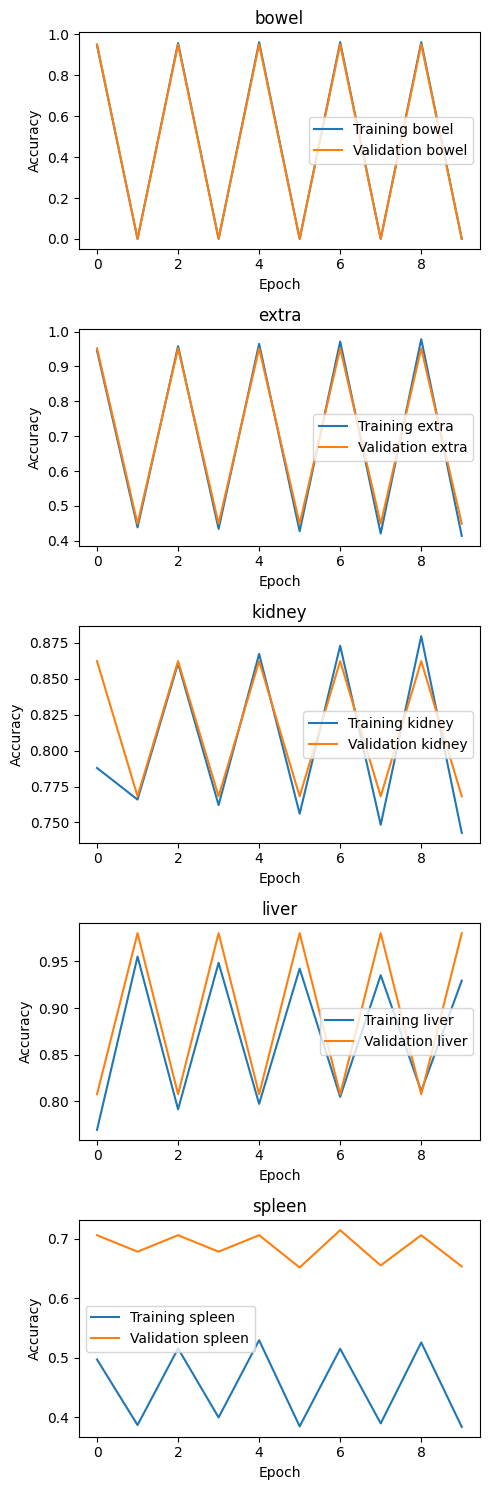

In [60]:
# Create a 3x2 grid for the subplots
fig, axes = plt.subplots(5, 1, figsize=(5, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training accuracy
    axes[i].plot(history.history[name + '_accuracy'], label='Training ' + name)
    # Plot validation accuracy
    axes[i].plot(history.history['val_' + name + '_accuracy'], label='Validation ' + name)
    axes[i].set_title(name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()

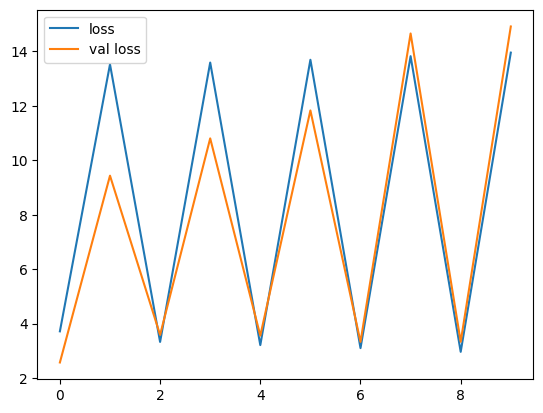

In [61]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [62]:
# store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

# Find mean accuracy
best_acc = np.mean(
    [best_acc_bowel,
     best_acc_extra,
     best_acc_liver,
     best_acc_kidney,
     best_acc_spleen
])


print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')

>>>> BEST Loss  : 2.575
>>>> BEST Acc   : 0.856
>>>> BEST Epoch : 0

ORGAN Acc:
  >>>> Bowel           : 0.952
  >>>> Extravasation   : 0.952
  >>>> Liver           : 0.807
  >>>> Kidney          : 0.862
  >>>> Spleen          : 0.706


**Loading the Stored Model**

In [63]:
from tensorflow.keras.models import load_model

import tensorflow as tf

# Specify the path to the SavedModel directory
saved_model_path = '/kaggle/working/my_model_savedmodel'

# Load the model
loaded_model = tf.keras.models.load_model(saved_model_path)

# You can now use loaded_model for inference or further training



**Deployment**

In [64]:
!pip install Flask



from flask import Flask, request, jsonify
import tensorflow as tf

app = Flask(__name__)

# Load the pre-trained model
model = tf.keras.models.load_model('/kaggle/working/my_model_savedmodel')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get the input data from the request
        data = request.get_json()
        # Assuming your input data is a dictionary with a key 'image' containing the image data

        # Preprocess the input data as needed (e.g., resize, normalize)

        # Make predictions using the loaded model
        predictions = model.predict(data['image'])

        # Convert predictions to a JSON response
        response = {
            'predictions': predictions.tolist()
        }
        return jsonify(response)

    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)


import requests
import json

# Replace 'input_data' with your actual input data
input_data = {'image': ...}

# Send a POST request to the Flask server
url = 'http://localhost:5000/predict'
headers = {'Content-Type': 'application/json'}
response = requests.post(url, data=json.dumps(input_data), headers=headers)

# Get the predictions from the response
predictions = response.json()['predictions']


**Models 4**

!pip install tensorflow==2.x


pip install --upgrade pip

pip install keras-tuner


import kerastuner as kt


# Define a function to build the model
def build_model(hp):
    inputs = keras.Input(shape=config.IMAGE_SIZE + (1,), batch_size=64)
    backbone = keras.applications.ResNet50(include_top=False, weights=None, input_tensor=inputs)
    x = backbone.output
    gap = keras.layers.GlobalAveragePooling2D()(x)
    
    # Hyperparameters to tune
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)
    weight_decay = hp.Float('weight_decay', min_value=1e-5, max_value=1e-2, sampling='log')
    
    x = keras.layers.Dropout(dropout_rate)(gap)
    
    # Define 'necks' for each head with 64 units
    units = 64
    x_bowel = keras.layers.Dense(units, activation='silu', kernel_regularizer=keras.regularizers.l2(weight_decay))(x)
    x_extra = keras.layers.Dense(units, activation='silu', kernel_regularizer=keras.regularizers.l2(weight_decay))(x)
    x_liver = keras.layers.Dense(units, activation='silu', kernel_regularizer=keras.regularizers.l2(weight_decay))(x)
    x_kidney = keras.layers.Dense(units, activation='silu', kernel_regularizer=keras.regularizers.l2(weight_decay))(x)
    x_spleen = keras.layers.Dense(units, activation='silu', kernel_regularizer=keras.regularizers.l2(weight_decay))(x)
    
    # Define heads for each target label
    out_bowel = keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel)
    out_extra = keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra)
    out_liver = keras.layers.Dense(3, name='liver', activation='softmax')(x_liver)
    out_kidney = keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney)
    out_spleen = keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen)
    
    model = keras.Model(inputs=inputs, outputs=[out_bowel, out_extra, out_liver, out_kidney, out_spleen])
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = {
        "bowel": keras.losses.BinaryCrossentropy(),
        "extra": keras.losses.BinaryCrossentropy(),
        "liver": keras.losses.CategoricalCrossentropy(),
        "kidney": keras.losses.CategoricalCrossentropy(),
        "spleen": keras.losses.CategoricalCrossentropy(),
    }
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

with tpu_strategy.scope():
    # Create a tuner
    tuner = kt.Hyperband(
        build_model,
        objective='val_loss',
        max_epochs=10,  # Maximum number of training epochs
        factor=3,        # Reduction factor for the number of models
        directory='hyperparameter_tuning',
        project_name='my_image_classification'
    )

    # Define callbacks for early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Perform hyperparameter tuning
    tuner.search(
        train_gen,
        steps_per_epoch=train_steps_per_epoch,
        validation_data=val_gen,
        validation_steps=val_steps_per_epoch,
        epochs=10,
        callbacks=[early_stopping],
    )

    # Get the best hyperparameters
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Train the final model with the best hyperparameters
    best_model = tuner.hypermodel.build(best_hyperparameters)
    best_model.summary()

    history = best_model.fit(
        train_gen,
        steps_per_epoch=train_steps_per_epoch,
        validation_data=val_gen,
        validation_steps=val_steps_per_epoch,
        epochs=50,  # You can adjust the number of epochs
        callbacks=[early_stopping],
    )

# Evaluate the final model
test_loss, test_accuracy = best_model.evaluate(test_gen, steps=test_steps)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


# Create a 3x2 grid for the subplots
fig, axes = plt.subplots(5, 1, figsize=(5, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training accuracy
    axes[i].plot(history.history[name + '_accuracy'], label='Training ' + name)
    # Plot validation accuracy
    axes[i].plot(history.history['val_' + name + '_accuracy'], label='Validation ' + name)
    axes[i].set_title(name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()

plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

import kerastuner as kt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pydicom
import cv2
import pandas as pd
import gc

# Define functions for reading DICOM images, augmentation, and image preprocessing (as provided earlier)

# Define your image generator and data loading (as provided earlier)

# Define a function to build the model
def build_model(hp):
    inputs = keras.Input(shape=config.IMAGE_SIZE + (1,), batch_size=64)
    backbone = keras.applications.DenseNet121(include_top=False, weights=None, input_tensor=inputs)
    x = backbone.output
    gap = keras.layers.GlobalAveragePooling2D()(x)
    
    # Hyperparameters to tune
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)
    weight_decay = hp.Float('weight_decay', min_value=1e-5, max_value=1e-2, sampling='log')
    
    x = keras.layers.Dropout(dropout_rate)(gap)
    
    # Define 'necks' for each head with 64 units
    units = 32
    x_bowel = keras.layers.Dense(units, activation='silu', kernel_regularizer=keras.regularizers.l2(weight_decay))(x)
    x_extra = keras.layers.Dense(units, activation='silu', kernel_regularizer=keras.regularizers.l2(weight_decay))(x)
    x_liver = keras.layers.Dense(units, activation='silu', kernel_regularizer=keras.regularizers.l2(weight_decay))(x)
    x_kidney = keras.layers.Dense(units, activation='silu', kernel_regularizer=keras.regularizers.l2(weight_decay))(x)
    x_spleen = keras.layers.Dense(units, activation='silu', kernel_regularizer=keras.regularizers.l2(weight_decay))(x)
    
    # Define heads for each target label
    out_bowel = keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel)
    out_extra = keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra)
    out_liver = keras.layers.Dense(3, name='liver', activation='softmax')(x_liver)
    out_kidney = keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney)
    out_spleen = keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen)
    
    model = keras.Model(inputs=inputs, outputs=[out_bowel, out_extra, out_liver, out_kidney, out_spleen])
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = {
        "bowel": keras.losses.BinaryCrossentropy(),
        "extra": keras.losses.BinaryCrossentropy(),
        "liver": keras.losses.CategoricalCrossentropy(),
        "kidney": keras.losses.CategoricalCrossentropy(),
        "spleen": keras.losses.CategoricalCrossentropy(),
    }
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

with tpu_strategy.scope():
    # Create a tuner
    tuner = kt.Hyperband(
        build_model,
        objective='val_loss',
        max_epochs=10,  # Maximum number of training epochs
        factor=3,        # Reduction factor for the number of models
        directory='hyperparameter_tuning',
        project_name='my_image_classification'
    )

    # Define callbacks for early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Perform hyperparameter tuning
    tuner.search(
        train_gen,
        steps_per_epoch=train_steps_per_epoch,
        validation_data=val_gen,
        validation_steps=val_steps_per_epoch,
        epochs=10,
        callbacks=[early_stopping],
    )

    # Get the best hyperparameters
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Train the final model with the best hyperparameters
    best_model = tuner.hypermodel.build(best_hyperparameters)
    best_model.summary()

    history = best_model.fit(
        train_gen,
        steps_per_epoch=train_steps_per_epoch,
        validation_data=val_gen,
        validation_steps=val_steps_per_epoch,
        epochs=50,  # You can adjust the number of epochs
        callbacks=[early_stopping],
    )

# Evaluate the final model
test_loss, test_accuracy = best_model.evaluate(test_gen, steps=test_steps)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
